# Introduction: Finding Supernova Neutrinos
Supernovae are stellar explosions that produce enormous quantities of neutrinos. These neutrinos escape the stellar core hours before the optical explosion becomes visible, making their detection a potential early warning system for supernova events. As we can learn a great deal about high-energy Physics from spectroscopic data of supernovae events, having an early warning system in place would be beneficial to the field of Physics.

To date, we have only managed to detect the neutrinos from one supernova, which arrived at Earth on the 23rd February 1987 and is known by the snappy name SN1987A. This project will investigate the feasibility of identifying supernova neutrino events in a new type of detector called a Liquid-Argon Time-Projection Chamber (LArTPC). These detectors give incredibly high-resolution 'images' of the charged-particle tracks produced when a neutrino interacts in the detector. 

This notebook aims to use machine learning techniques to analyze simulated data from a LArTPC. Our goal is to identify supernova neutrino events, reconstruct their properties, and distinguish them from background noise. 

### Data
The data for this project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| larImages.npy | A numpy array of 10,000 100x100 pixel images |
| meta.npy | The meta information about the particles in the image |

The images show the energy deposited in the liquid argon detector within a small slice of space and time. The meta information contains the following 64 numbers for each image. The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.).

| Column | Description |
| ----------- | ----------- |
| 0 | Row number |
| 1 | Neutrino Energy (MeV) |
| 2 | Initial state particles (always 2) |
| 3 | Final state particles (varies) |
| 4-8 | Initial Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 9-13 | Initial Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 14-18 | Final Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 19-23 | Final Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| $\vdots$ | Final Particle N: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 59-63 | Final Particle 10: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |

### Machine Learning Tasks
1. Write a method to simulate electronic noise in the detector. The electronic noise is expected to follow a normal distribution.
2. Develop a machine learning classifier that can successfully classify 'clean' simulated neutrinos from 'empty' slices with electronic noise.
3. Test the machine learning classifier on simulated neutrinos overlaid with noise, and discern what level of additional noise begins to impact the ML algorithm.

#### Potential extensions
1. Write a method to generate noise in the 100x100 pixel images to simulate radioactive noise. This noise should be in the form of randomly placed Gaussian 'blobs' with appropriate energy. Repeat the above tests with radioactive noise. Determine whether radioactive noise is more or less of a problem than electronic noise.
2. Write a machine learning algorithm that can determine either the electron energy or (even better) the neutrino energy. What is the best energy resolution that can be achieved by such an algorithm?
3. Write a machine learning algorithm to effectively denoise either the electronic noise or radioactive noise datasets.
4. Write a machine learning algorithm to determine the number of finan state particles in the image.

In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
import keras.layers
import keras_tuner as kt
import sklearn
from sklearn import metrics
from tqdm import tqdm
from keras import layers, models, Input, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

# Might need
from numpy.random import random_integers

# Load raw data from simulation
lar_images = np.load('larImages.npy')
metadata = np.load('meta.npy')

In [2]:
# Check shape of data
print("--------------------------------")
print("Data shape:")
print(f"- Images: {lar_images.shape} - {lar_images.shape[0]} images, {lar_images.shape[1]} pixels wide, {lar_images.shape[2]} pixels high")
print(f"- Metadata: {metadata.shape}")
print("--------------------------------")
print(f'Metadata check:')
for i in range(3):
    print("- Row",int(metadata[i][0]),"corresponds to a neutrino of",metadata[i][1], "MeV and produced",int(metadata[i][3]),"final state particles")
print("--------------------------------")


--------------------------------
Data shape:
- Images: (10000, 100, 100) - 10000 images, 100 pixels wide, 100 pixels high
- Metadata: (10000, 64)
--------------------------------
Metadata check:
- Row 0 corresponds to a neutrino of 21.2005 MeV and produced 6 final state particles
- Row 1 corresponds to a neutrino of 21.8617 MeV and produced 3 final state particles
- Row 2 corresponds to a neutrino of 17.6584 MeV and produced 4 final state particles
--------------------------------


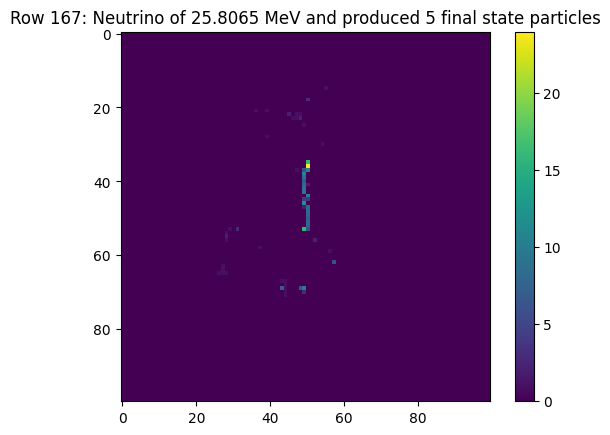

In [3]:
# Taking a sample image to plot and check its properties
sample_image_no = random.randint(0,lar_images.shape[0])

plt.figure()
plt.imshow(lar_images[sample_image_no])
plt.colorbar()
plt.title(f'Row {sample_image_no}: Neutrino of {metadata[sample_image_no][1]} MeV and produced {int(metadata[sample_image_no][3])} final state particles')
plt.show()

In [4]:
# Taking some statistics to better understand the dataset
print("Data statistics & properties:")
print("")
print("--------IMAGE INTENSITY-----------")
print(f'Max intensity across all images: {np.max(lar_images)}')
print(f'Image intensity range: {np.min(lar_images)} - {np.max(lar_images)}')
print('')
print("---------NEUTRINO ENERGY----------")
print(f'Mean neutrino energy: {np.mean(metadata[:,1]):.2f}')
print(f' Neutrino energy range: {np.min(metadata[:,1]):.2f} - {np.max(metadata[:,1]):.2f}')
print("")
print("------FINAL STATE PARTICLES-------")
print(f'Range of final state particles: {np.min(metadata[:,3])} - {np.max(metadata[:,3])}')
print(f'Mean of final state particles: {np.mean(metadata[:,3]):.2f}')


Data statistics & properties:

--------IMAGE INTENSITY-----------
Max intensity across all images: 106.0
Image intensity range: 0.0 - 106.0

---------NEUTRINO ENERGY----------
Mean neutrino energy: 21.65
 Neutrino energy range: 4.49 - 59.93

------FINAL STATE PARTICLES-------
Range of final state particles: 3.0 - 10.0
Mean of final state particles: 5.18


# Task 1: Generating Electronic Noise

First we define a function to generate gaussian noise centered at 0, with a standard deviation $\sigma$ variable of 'stdev', which controls the noise intensity and spread. Noisy values below zero are clipped as electronic intereference cannot be negative. 

In [2]:
def gaussian_noise(shape,stdev):
    '''
    Generates Gaussian noise centered at intensity value 0, 'clipping' negative values below zero as electronic 
    interference cannot be negative. Noise can be added at varying intensities of standard deviation using 'stdev'.

    Inputs:
    - shape: shape of the image dataset to add noise to
    - stdev: vary the standard deviation (spread/width) of noise generated

    Output:
    - noise: image dataset with added noise
    '''
    # Generate noise array
    noise_array = np.random.normal(0, stdev, shape)

    # Clip negative values
    noise_array = noise_array.clip(min=0)

    return noise_array



Now we do a quick visualisation of noise to ensure the function works correctly:

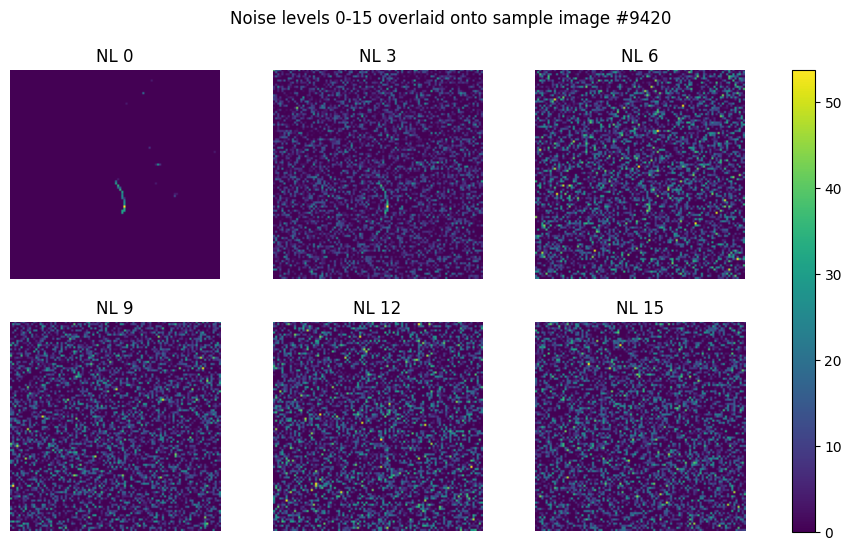

In [6]:
noise_stdev = 0  # starts at 0 sigma
sample_image_no = random.randint(0,lar_images.shape[0])
sample_image = lar_images[sample_image_no]   # sample image from dataset

# Figure with 2 columns, 3 rows of subplots
fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))

# Loop through subplots, generate noisy images, and plot
for ax in axes.flat:
    noisy_image = sample_image + gaussian_noise(lar_images.shape, noise_stdev)
    im = ax.imshow(noisy_image[0])
    
    # Stylisation, titles
    ax.set_title(f'NL {noise_stdev}')
    ax.axis('off')
    noise_stdev+=3
    
fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle(f'Noise levels 0-{noise_stdev-3} overlaid onto sample image #{sample_image_no}')
plt.show()
        

### Visualisation of Maximum Intensity, Energies Distribution

The `max_intensity` function is defined to return the highest intensity (largest pixel value) for each 100x100 image slice, i.e. 10,000 intensity values for the raw data we are working with. This function will help in visualising the intensity distribution of datasets without noise, as well as with varying levels of noise.

In [3]:
def max_intensity_per_image(images):
    '''
    Returns an array of the maximum intensity for each image within an image dataset.

    Inputs:
    - images: Image dataset of shape (images, height, width)

    Output:
    - max_intensity: Array of maximum pixel values (intensity) for each image within the dataset.
    '''
    # Collapse axes 1 and 2 (width/height), leaving a 1D array of maximum pixel values per each image
    max_intensity = np.max(images, axis=(1, 2))
    
    return max_intensity

Now, we generate some plots to observe the distribution of maximum intensity values from each slice in the `images` dataset (left plot), as well as distribution from varying noise levels (NL) from 2-22 (middle). We also take a look at the distribution of neutrino and electron energies in the right-most plot.

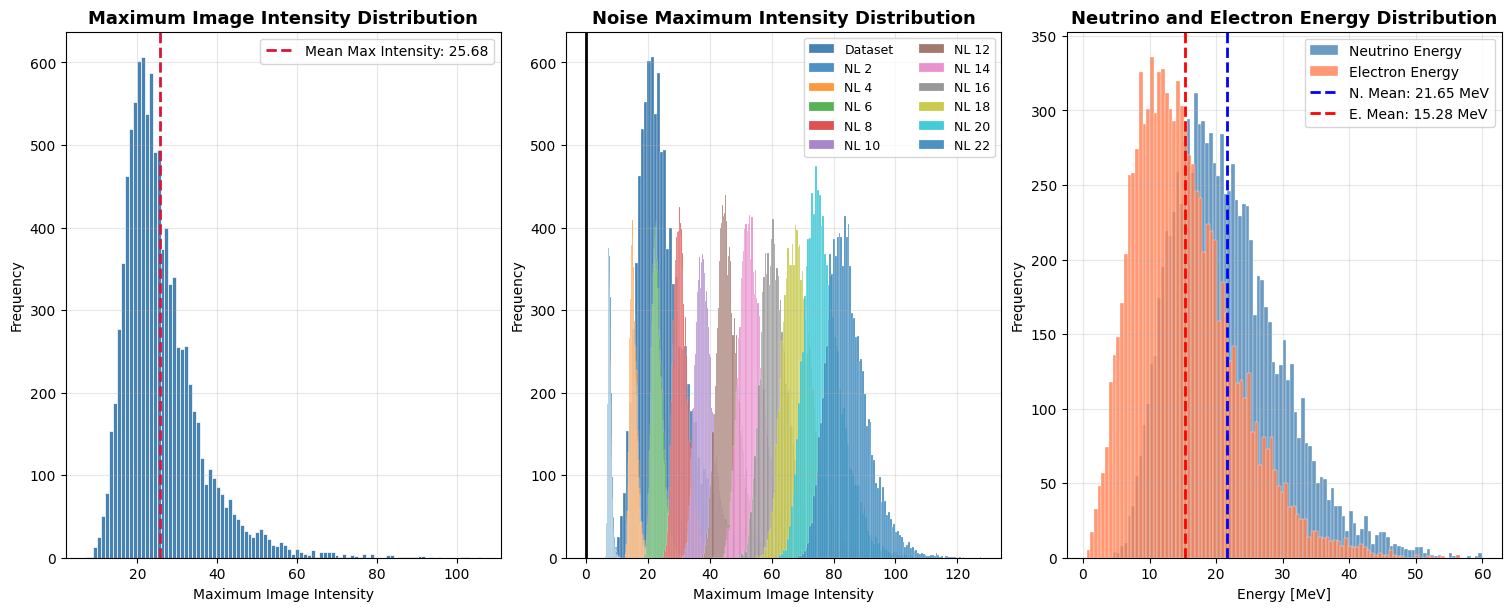

In [8]:
max_intensity_values = max_intensity_per_image(lar_images)

# Create figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 6), constrained_layout=True)

# ---------------------------------------------------------------------------
# Left Plot: Maximum Intensity Value Distribution
# ---------------------------------------------------------------------------
ax[0].hist(max_intensity_values, bins=100, color='steelblue',
           edgecolor='white', linewidth=0.5)
ax[0].axvline(np.mean(max_intensity_values), c='crimson', ls='--', lw=2,
              label=f'Mean Max Intensity: {np.mean(max_intensity_values):.2f}')
ax[0].set_title('Maximum Image Intensity Distribution', fontsize=13, weight='bold')
ax[0].set_xlabel('Maximum Image Intensity')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[0].grid(alpha=0.3)

# ---------------------------------------------------------------------------
# Middle Plot: Noise Maximum Image Intensity Distribution
# ---------------------------------------------------------------------------
# Generate noise at varying standard deviations and plot max pixel distributions
noise_image_shape = (10000, lar_images.shape[1], lar_images.shape[2])

# Plot original dataset
ax[1].hist(max_intensity_values,bins=100,color='steelblue',alpha=1.0,
                label=f'Dataset', edgecolor='white',linewidth=0.2)

for noise_stdev in np.arange(2, 23, 2):
    # Generate noise with current standard deviation
    noise_images = gaussian_noise(noise_image_shape, noise_stdev)

    # Calculate max intensity for each noise image
    noise_max_values = max_intensity_per_image(noise_images)

    # Plot noise in histogram
    ax[1].hist(noise_max_values, bins=100, alpha=0.8,
               label=f'NL {noise_stdev}', edgecolor='white', linewidth=0.2)

# Add zero reference line
ax[1].axvline(x=0, c='black', lw=2)
ax[1].set_title('Noise Maximum Intensity Distribution', fontsize=13, weight='bold')
ax[1].set_xlabel('Maximum Image Intensity')
ax[1].set_ylabel('Frequency')
ax[1].legend(fontsize=9, ncol=2)
ax[1].grid(alpha=0.3)

# ---------------------------------------------------------------------------
# Right Plot: Energy Distributions from Metadata
# ---------------------------------------------------------------------------
# Extract neutrino energy (column 1) and electron energy (column 15)
neutrino_energy = metadata[:, 1]
electron_energy = metadata[:, 15]

# Plot overlapping histograms with transparency
ax[2].hist(neutrino_energy, bins=100, color='steelblue', alpha=0.8,
           label='Neutrino Energy', edgecolor='white', linewidth=0.3)
ax[2].hist(electron_energy, bins=100, color='coral', alpha=0.8,
           label='Electron Energy', edgecolor='white', linewidth=0.3)

# Add mean lines
ax[2].axvline(np.mean(neutrino_energy), c='b', ls='--', lw=2,
              label=f'N. Mean: {np.mean(neutrino_energy):.2f} MeV')
ax[2].axvline(np.mean(electron_energy), c='r', ls='--', lw=2,
              label=f'E. Mean: {np.mean(electron_energy):.2f} MeV')

ax[2].set_title('Neutrino and Electron Energy Distribution', fontsize=13, weight='bold')
ax[2].set_xlabel('Energy [MeV]')
ax[2].set_ylabel('Frequency')
ax[2].legend()
ax[2].grid(alpha=0.3)

plt.show()


#### Observations

For the middle plot, a noise level of 22 is selected as the upper limit as its bell curve no longer visually overlaps with the original `images` dataset. However, it is expected that the model will struggle above noise levels of 12 as the majority of peak intensities begin to obscure that of the original dataset.

The energy distribution seems to resemble that of the maximum intensity distribution, although has a mildly larger spread and a less strong peak.



### Preprocessing: Image normalisation

Here, the `normalise_intensity` function is defined to rescale the pixel values across each image to between [0,1] for improved ML algorithm performance as neural networks are sensitive to feature ranges. Min-max normalisation is used, which is defined by the following formula:
$$x_{norm}=\frac{x-\min{x}}{\max{x}-\min{x}}$$
It's typically used for scaling as it's simple and preserves the original data shape.

In [4]:
def normalise_intensity(images):
    '''
    Normalises the intensity of each pixel in the image dataset to a range of 0-1.

    Inputs:
    - images: Image dataset to normalise

    Outputs:
    - normalised_images: Image dataset with pixel values normalised to [0,1]
    '''

    # Calculate minimum and maximum values
    min_val = np.min(images)
    max_val = np.max(images)
    
    # Min-max normalisation
    normalised_images = (images - min_val) / (max_val - min_val)

    return normalised_images

Now we do a quick test for the normalisation function.

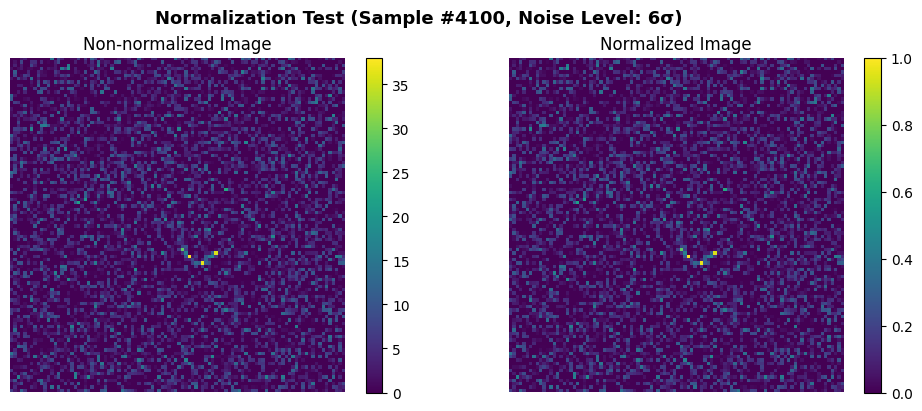

In [10]:
# Select random sample image and add noise
sample_image_no = np.random.randint(0, lar_images.shape[0])
sample_image = lar_images[sample_image_no]

# Create noisy image and normalise
noise_level = 6
noisy_image = sample_image + gaussian_noise(sample_image.shape, noise_level)
normalized_noisy_image = normalise_intensity(noisy_image)

# Create figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
fig.suptitle(f'Normalization Test (Sample #{sample_image_no}, Noise Level: {noise_level}σ)',
             fontsize=13, weight='bold')

# Left: Non-normalized
im1 = ax[0].imshow(noisy_image)
ax[0].set_title('Non-normalized Image')
ax[0].axis('off')
fig.colorbar(im1, ax=ax[0])

# Right: Normalized
im2 = ax[1].imshow(normalized_noisy_image)
ax[1].set_title('Normalized Image')
ax[1].axis('off')
fig.colorbar(im2, ax=ax[1])

plt.show()



# Task 2: Binary Classifier - Clean neutrino data vs. Empty noise slice

Task 2 covers an easy case of discerning clean neutrino slices from empty noise. A simple model should be able to achieve an accuracy of 1.0 at every noise level considered. As such, I will try to challenge myself and make the model as simple as possible while still achieving 1.0 validation accuracy.

### Function to generate training, validation and testing datasets

It is understood that it's better to have varying noise values within the training dataset, as this results in more robust networks as they are exposed to more varied noise conditions. As such, the noise for each image (overlaid or not overlaid onto neutrinos) will be randomised from a noise_range.

In [11]:
trn_val_tst_ratio = [0.7,0.15,0.15]  # training, validation, testing ratio

def prepare_training_data(images, num_of_images, overlaid_noise, noise_range, trn_val_tst_ratio=[0.7,0.15,0.15]):
    '''
    Generates training, validation and testing datasets for CNN binary classification. Half of the images are neutrinoless (label 0)
    and half will contain neutrinos (label 1). Images are also normalised and shuffled for more effective training of CNNs.

    Inputs:
    - images: Neutrino image dataset of shape (num_images, height, width)
    - num_of_images: Number of total training, validation and testing images to output (includes both 1 and 0 images)
    - overlaid_noise: Boolean. True for overlaid noise i.e. noise is added to both neutrino and neutrinoless images
    - noise_range: Range of noise to be inputted into the training data. Example is [0,2] for 0-2 range.
    - trn_val_tst_ratio: Array with fraction of data to be split into training, testing and validation data (default: 0.70-0.15-0.15)

    Outputs:
    - X_train, y_train: Training images and labels
    - X_val, y_val: Validation images and labels
    - X_test, y_test: Test images and labels

    All X arrays have shape (num_samples, height, width, 1) for CNN input
    All y arrays have shape (num_samples,) with binary labels (0 or 1)
    '''
    num_per_type = int(num_of_images/2)  # number of neutrino and neutrinoless images

    # Shuffle images dataset
    shuffled_indices = np.random.permutation(len(images))
    images = images[shuffled_indices]

    # Create neutrino images and neutrino labels
    neutrino_images = images[:num_per_type].copy()
    neutrino_labels = np.ones(num_per_type,dtype=int)

    # Conditional: Add noise to neutrino images if 'overlaid_noise' is true
    if overlaid_noise == True:
        # Add random noise for each image
        for i in range(len(neutrino_images)):
            neutrino_images[i] = neutrino_images[i] + gaussian_noise((1,100,100),random.uniform(noise_range[0],noise_range[1]))

    # Generate noise-only images - all have label 0
    noise_only_images = []
    for i in range(len(neutrino_images)):
        noise_only_images.append(gaussian_noise((100,100), random.uniform(noise_range[0],noise_range[1])))
        noise_only_labels = np.zeros(num_per_type, dtype=int)

    # Combine neutrino and noise-only images
    noise_only_images = np.array(noise_only_images)
    all_images = np.concatenate([neutrino_images, noise_only_images], axis=0)
    all_labels = np.concatenate([neutrino_labels, noise_only_labels], axis=0)

    # Normalize all images to [0, 1] range
    all_images_normalized = normalise_intensity(all_images)

    # Shuffle the combined dataset
    num_total = all_images_normalized.shape[0]
    shuffle_indices = np.random.permutation(num_total)
    all_images_shuffled = all_images_normalized[shuffle_indices]
    all_labels_shuffled = all_labels[shuffle_indices]

    # Extract training, validation, testing ratios
    train_ratio = trn_val_tst_ratio[0]
    val_ratio = trn_val_tst_ratio[1]

    # Calculate split indices
    train_end = int(train_ratio * num_total)
    val_end = train_end + int(val_ratio * num_total)

    # Split data
    X_train = all_images_shuffled[:train_end]
    y_train = all_labels_shuffled[:train_end]

    X_val = all_images_shuffled[train_end:val_end]
    y_val = all_labels_shuffled[train_end:val_end]

    X_test = all_images_shuffled[val_end:]
    y_test = all_labels_shuffled[val_end:]

    # Add channel dimension: (num_samples, height, width) → (num_samples, height, width, 1)
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    return X_train, y_train, X_val, y_val, X_test, y_test

### Visualisations: Validating Dataset Function

Now we can conduct some testing and visualisations to ensure the generated datasets are valid. 

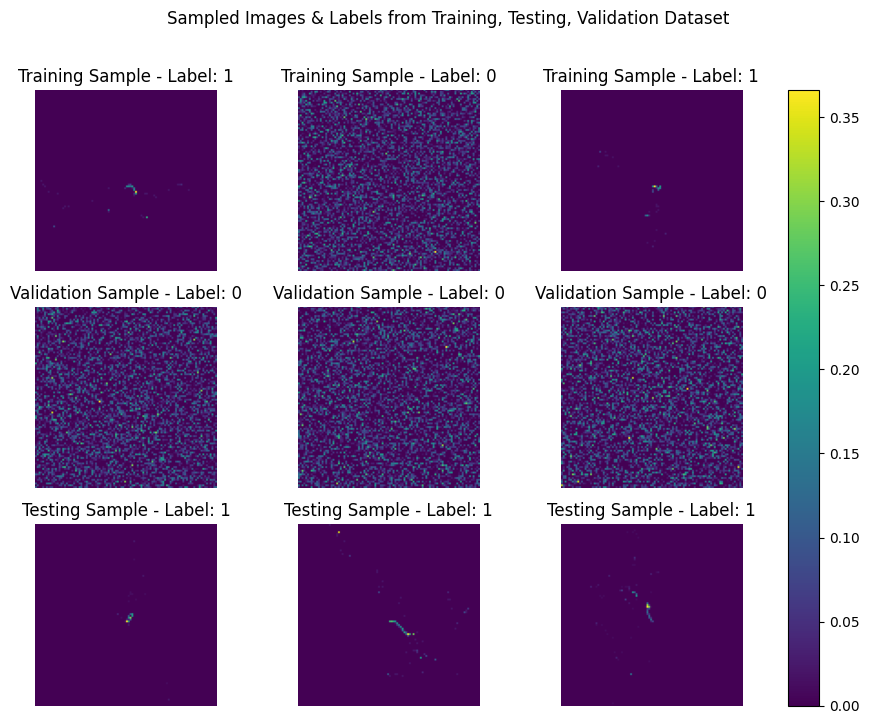

In [12]:
# Generate training, validation, and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = prepare_training_data(
    lar_images,
    num_of_images=1000,
    overlaid_noise=False,
    noise_range=[0,12]
)

# Figure with 3 columns, 3 rows of subplots
fig,axes = plt.subplots(nrows=3, ncols=3, figsize=(12,8))

# Loop through subplots, sample an image from training/validation/testing datasets, and plot
for count,ax in enumerate(axes.flat,start=1):
    if count in range(1,4):   # If first row, sample trom training images
        sample_no = random.randint(0,X_train.shape[0])
        im = ax.imshow(X_train[sample_no])
        
        # Stylisation
        ax.set_title(f'Training Sample - Label: {y_train[sample_no]}')
        ax.axis('off')
    
    if count in range(4,7):   # If second row, sample trom validation images
        sample_no = random.randint(0,X_val.shape[0])
        im = ax.imshow(X_val[sample_no])
        
        # Stylisation
        ax.set_title(f'Validation Sample - Label: {y_val[sample_no]}')
        ax.axis('off')

    if count in range(7,10):   # If third row, sample trom testing images
        sample_no = random.randint(0,X_test.shape[0])
        im = ax.imshow(X_test[sample_no])
        
        # Stylisation
        ax.set_title(f'Testing Sample - Label: {y_test[sample_no]}')
        ax.axis('off')
    
fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle(f'Sampled Images & Labels from Training, Testing, Validation Dataset')
plt.show()
        


### Model Creation

Now, let's create our simple CNN. Here, a very simple CNN is defined based on the older AlexNet, developed by Kirshevsky, containing 3 convolutional blocks and a dropout layer. 

In [13]:
task2_model = keras.Sequential([
    # First convolutional block
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100,100,1)),
    keras.layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),

    # Dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
    ])
    
# Compile model
task2_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

task2_model.summary()


/Users/alexpugeat/Documents/Local/supernova/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 465,473 (1.78 MB)

 Trainable params: 465,473 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

Now we can train the model on some data:

In [14]:
# Generate training data
X_train, y_train, X_val, y_val, X_test, y_test = prepare_training_data(
    lar_images,
    num_of_images=10000,
    overlaid_noise=False,
    noise_range=[4,22]
)

# Train model
print(f'Training Task 2 Model:')
history = task2_model.fit(
    X_train,y_train,
    epochs=3,
    batch_size=32,
    validation_data=(X_val,y_val),
    verbose=1
)

# Evaluate on test data
print(f'Testing Task 2 Model:')
test_loss, test_accuracy = task2_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = task2_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print(f'Classification Report:')
print(metrics.classification_report(y_test, y_pred, target_names=['Noise', 'Neutrino']))



Training Task 2 Model:
Epoch 1/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9819 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss: 5.0696e-09
Epoch 2/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 1.0000 - loss: 2.0220e-05 - val_accuracy: 1.0000 - val_loss: 8.0159e-09
Epoch 3/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 1.0000 - loss: 6.0359e-06 - val_accuracy: 1.0000 - val_loss: 1.1176e-10
Testing Task 2 Model:
Test Loss: 0.0000
Test Accuracy: 1.0000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classification Report:
              precision    recall  f1-score   support

       Noise       1.00      1.00      1.00       776
    Neutrino       1.00      1.00      1.00       724

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



### Observations

As expected, the model is able to easily discern pure noise from clean neutrino images, reaching a training and validation accuracy of 1.0 within 2 epochs. Test accuracy is 1.0 and loss at 0.0.

This is also reflected in the classification report, which considers the following metrics:

#### Precision
$$\textup{Precision}=\frac{\textup{True Positives}}{\textup{True Positives} + \textup{False Positives}}$$
This metric measures the rate of false positives, i.e. how often the model will claim a neutrino is present when it isn't. The result of 1.00 means that the model produced zero false positives from the entire testing dataset.

#### Recall
$$\textup{Precision}=\frac{\textup{True Positives}}{\textup{True Positives} + \textup{False Negatives}}$$
This metric measures how many neutrinos the model missed, i.e. out of all neutrinos from the dataset, how many were found. With a recall score of 1.00, all 761 neutrino images were found.

#### F1-Score
$$\textup{Precision}=\frac{\textup{Precision}\times\textup{Recall}}{\textup{Precision} + \textup{Recall}}$$
This score balances the precision and recall metrics, essentially combining the two. As both are measured 1.00, the F1-Score is also 1.00.

#### Support
The number of each class (noise / neutrino) being tested on. There were 739 noise images and 761 neutrino images.


# Task 3: Binary Classifier - Neutrinos with Overlaid Noise

Now the task becomes more challenging as we introduce noise onto the neutrinos.

### Model Creation

A mini version of the ResNet-18 architecture is adapted for this task.


In [5]:
# Returns an activation function for our residual block hidden layers so we can customise them. Will be more useful in task 5.
def get_activation_layer(x,type_name):
    if type_name=='leaky_relu':
        return layers.LeakyReLU(alpha=0.1)(x)
    elif type_name=='swish':
        return layers.Activation('swish')(x)
    else:
        return layers.Activation('relu')(x)

def residual_block(x, filters, stride,activation='relu'):
    """
    A standard ResNet Identity Block.
    
    Args:
        x: Input tensor
        filters: Number of filters (feature maps)
        stride: Stride size (used for downsampling)
        activation: Activation function to be used. Select from 'leaky_relu','swish','relu'.
    """
    shortcut = x
    
    # First Conv Layer
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = get_activation_layer(x,type_name=activation)
    
    # Second Conv Layer
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    # Shortcut Adjustment
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = get_activation_layer(x,type_name=activation)
    return x

def build_resnet_mini(lossmode='binary_crossentropy',metric='accuracy',input_shape=(100,100,1)):
    inputs = Input(shape=(100,100,1))
    
    # Stem
    # We start with a standard conv layer to get feature extraction started
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # STACK 1 
    x = residual_block(x, filters=32, stride=1)
    x = residual_block(x, filters=32, stride=1) 

    # STACK 2 
    x = residual_block(x, filters=64, stride=2)
    x = residual_block(x, filters=64, stride=1) 

    # STACK 3 
    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128, stride=1) 

    # STACK 4 
    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256, stride=1) 

    # HEAD
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile model
    model.compile(
    optimizer='adam',
    loss=lossmode,
    metrics=[metric]
    )

    return model

task3_model = build_resnet_mini()
task3_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 100,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 100,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 100,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 100, 100,  │      9,216 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 100,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 100, 100,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 100,  │      9,216 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 100, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 100, 100,  │      9,216 │ activation_3[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 100, 100,  │          0 │ batch_normalizat

 Total params: 2,799,521 (10.68 MB)

 Trainable params: 2,794,721 (10.66 MB)

 Non-trainable params: 4,800 (18.75 KB)

### Training the Model

The next question that needs to be answered is what range of noise to train the model on. Here, we choose to identify the maximum noise the model can deal with, and increase that by 10-20%. This ensures the model is well prepared for typical noise ranges.

Here, we select a range of 0-13 noise level to train our model. It was observed that noise ranges any higher than this would cause the model to struggle to pick up features, and the accuracy would remain at around 50%.

In the cell below, we initialise and train our model:

In [19]:
# Create model
task3_model = build_resnet_mini()   

# Create Training, Validation, Testing Datasets
X_train, y_train, X_val, y_val, X_test, y_test = prepare_training_data(
    lar_images,
    num_of_images=10000,
    overlaid_noise=True,
    noise_range=[0,13]
)

# Train model
print(f'Training Task 3 Model:')
history = task3_model.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val,y_val),
    verbose=1
)

Training Task 3 Model:
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 129s 574ms/step - accuracy: 0.4943 - loss: 0.8351 - val_accuracy: 0.4960 - val_loss: 0.7123
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 568ms/step - accuracy: 0.5014 - loss: 0.7424 - val_accuracy: 0.4980 - val_loss: 1.2559
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 125s 571ms/step - accuracy: 0.6144 - loss: 0.6355 - val_accuracy: 0.4960 - val_loss: 48.5774
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 574ms/step - accuracy: 0.7733 - loss: 0.4115 - val_accuracy: 0.7547 - val_loss: 0.4227
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 575ms/step - accuracy: 0.8193 - loss: 0.3427 - val_accuracy: 0.7760 - val_loss: 0.4523
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 575ms/step - accuracy: 0.8614 - loss: 0.2969 - val_accuracy: 0.8673 - val_loss: 0.2789
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 133s 606ms/step - accuracy: 0.8801 - loss: 0.2619 - val_accuracy: 0.7747 - val_loss: 0.5412
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 127s 581ms/s

### Model Evaluation (using mixed noise tests)

Now we can evaluate the model, generating metrics for its performance with our varied-noise testing dataset.

Testing Task 3 Model on Mixed Noise Dataset:
Test Loss: 0.4316
Test Accuracy: 0.8773
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step
Classification Report:
              precision    recall  f1-score   support

       Noise       0.83      0.95      0.89       761
    Neutrino       0.94      0.80      0.87       739

    accuracy                           0.88      1500
   macro avg       0.89      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



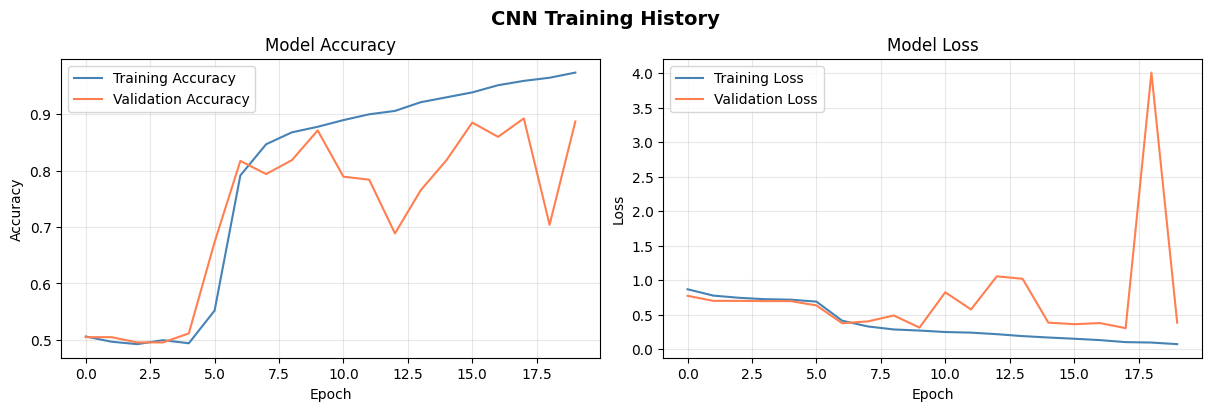

In [ ]:
# Evaluate on test data
print(f'Testing Task 3 Model on Mixed Noise Dataset:')
test_loss, test_accuracy = task3_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = task3_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print(f'Classification Report:')
print(metrics.classification_report(y_test, y_pred, target_names=['Noise', 'Neutrino']))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig.suptitle('CNN Training History', fontsize=14, weight='bold')

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='steelblue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='coral')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', color='steelblue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='coral')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.show()

### Observations

It is evident that our mini-ResNet model performs quite well on the mixed noise dataset, achieving a test accuracy of 87.73% and test loss of 0.4316 considering Gaussian noise goes up to 13$\sigma$. 

With a neutrino precision of 0.94, the model is trustworthy at identifying neutrinos, indicating few false positives. However, the recall for neutrinos is quite low at 0.80, indicating the model misses ~20% of neutrino events. It seems the model has adopted a bias towards defaulting to labelling images as noise when uncertain.

This is a good scenario for preventing false alarms (which would be costly), but at the same time unfortunate seeing as supernova neutrinos are such rare occurrences. 

The validation accuracy as well as loss appears to spike quite often, indicating the model is unstable. This can be due to either learning rate being too large, or "bad batches". With too large a learning rate, the optimiser might 'overshoot' during batches and cause the model to veer off-course. With batches, too small a batch size might result in the model experiencing 'bad batches' of difficult samples, resulting in high variance.

**Conclusion:** Add a `ReduceLROnPlateau` callback to allow the model to learn at a finer rate as it converges.

In [ ]:
# Create model
task3_model_v2 = build_resnet_mini()   

# Introduce LR Callback
reduce_lr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train model
print(f'Training Task 3 v2 Model')
history = task3_model_v2.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val,y_val),
    callbacks=[reduce_lr],
    verbose=1
)

Training Task 3 v2 Model
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 133s 593ms/step - accuracy: 0.4979 - loss: 0.8521 - val_accuracy: 0.5107 - val_loss: 0.6930 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 135s 618ms/step - accuracy: 0.5213 - loss: 0.7138 - val_accuracy: 0.5073 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 131s 598ms/step - accuracy: 0.7406 - loss: 0.4623 - val_accuracy: 0.7447 - val_loss: 0.7892 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 130s 593ms/step - accuracy: 0.8277 - loss: 0.3475 - val_accuracy: 0.7127 - val_loss: 0.6243 - learning_rate: 0.0010
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 577ms/step - accuracy: 0.8539 - loss: 0.3066 - val_accuracy: 0.8287 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 127s 578ms/step - accuracy: 0.8674 - loss: 0.2782 - val_accuracy: 0.5033 - val_loss: 5.2815 - learning_rate: 0.0010
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━

Now we test the model on different levels of noise, to see how it performs on isolated test batches of noise for each level:

NL 0 TEST:
Test Accuracy: 1.0000
Test Loss: 0.0014
NL 2 TEST:
Test Accuracy: 0.9987
Test Loss: 0.0049
NL 4 TEST:
Test Accuracy: 0.9873
Test Loss: 0.0476
NL 6 TEST:
Test Accuracy: 0.9347
Test Loss: 0.2363
NL 8 TEST:
Test Accuracy: 0.8387
Test Loss: 0.5255
NL 10 TEST:
Test Accuracy: 0.7693
Test Loss: 0.7877
NL 12 TEST:
Test Accuracy: 0.7000
Test Loss: 1.0869
NL 14 TEST:
Test Accuracy: 0.6840
Test Loss: 0.8887
NL 16 TEST:
Test Accuracy: 0.6440
Test Loss: 1.0907
NL 18 TEST:
Test Accuracy: 0.6347
Test Loss: 0.6833


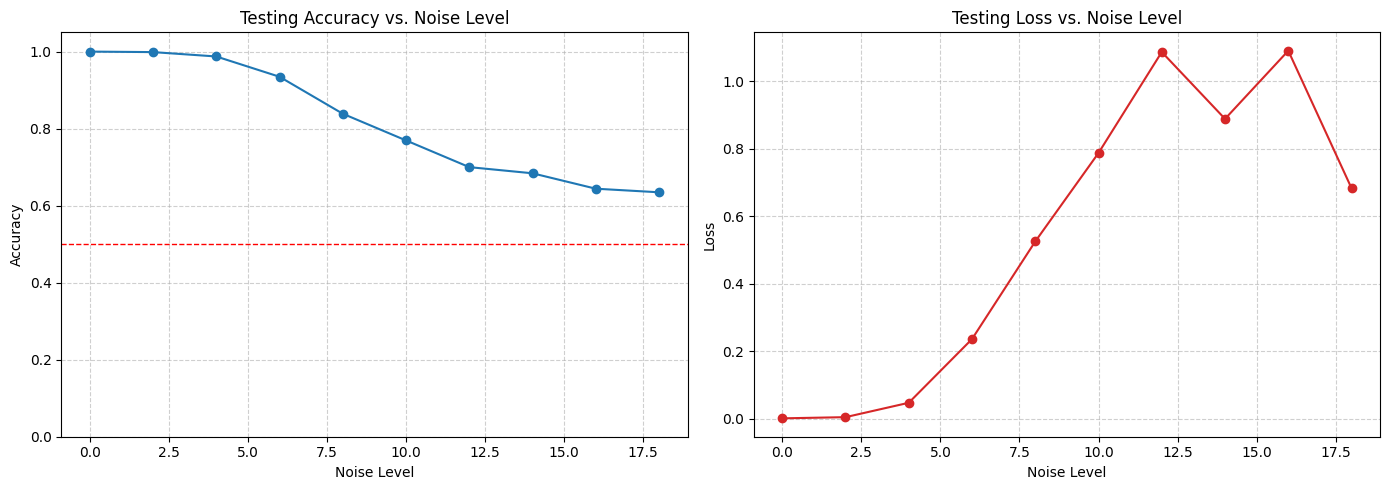

In [ ]:
# Testing Noise Ranges from 0-14:
noise_range=[0,18]

# Store the testing loss and accuracies for graphing
noise_record=[]
test_accuracy_record=[]
test_loss_record=[]

# Loop through each noise range with step 2
for i in range(noise_range[0],noise_range[1]+2,2):
    # Generate testing data for each noise level
    X_train, y_train, X_val, y_val, X_test, y_test = prepare_training_data(
    lar_images,
    num_of_images=10000,
    overlaid_noise=True,
    noise_range=[i,i]
    )
    # Test model on testing datasets for noise at this level
    print(f'NL {i} TEST:')
    test_loss, test_accuracy = task3_model_v2.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")    
    print(f"Test Loss: {test_loss:.4f}")

    # Append the loss, accuracy record lists
    noise_record.append(i)
    test_accuracy_record.append(test_accuracy)
    test_loss_record.append(test_loss)

# Create a figure with 2 subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Accuracy
ax1.plot(noise_record, test_accuracy_record, marker='o', color='tab:blue', label='Accuracy')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
ax1.set_title('Testing Accuracy vs. Noise Level')
ax1.set_xlabel('Noise Level')
ax1.set_ylabel('Accuracy')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylim(0, 1.05)  # Set y-axis to range from 0 to 1 for clarity

# Subplot 2: Loss
ax2.plot(noise_record, test_loss_record, marker='o', color='tab:red', label='Loss')
ax2.set_title('Testing Loss vs. Noise Level')
ax2.set_xlabel('Noise Level')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to prevent overlap and display
plt.tight_layout()
plt.show()


### Observations

It's evident that the model works best at a range of 0-4$\sigma$, maintaining testing accuracy at around 98% with negligible loss. However, past 6$\sigma$, the accuracy begins to break down, gradually decreasing to near random change at 0.56 accuracy. 

Again, we observe that loss spirals out of control for higher noise conditions, reaching 1.7630 at 16$\sigma$. This again suggests that our model confidently misidentifies high-variance noise as positive signal tracks.



<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
/var/folders/p2/k51tfdfd4k1dsdfzbs653xkh0000gn/T/ipykernel_15933/2966614510.py:32: SyntaxWarning: invalid escape sequence '\s'
  ax[i].hist(noise_dist, bins=50, color='r', label=f'Noise Only ({j}$\sigma$)', alpha=0.5)


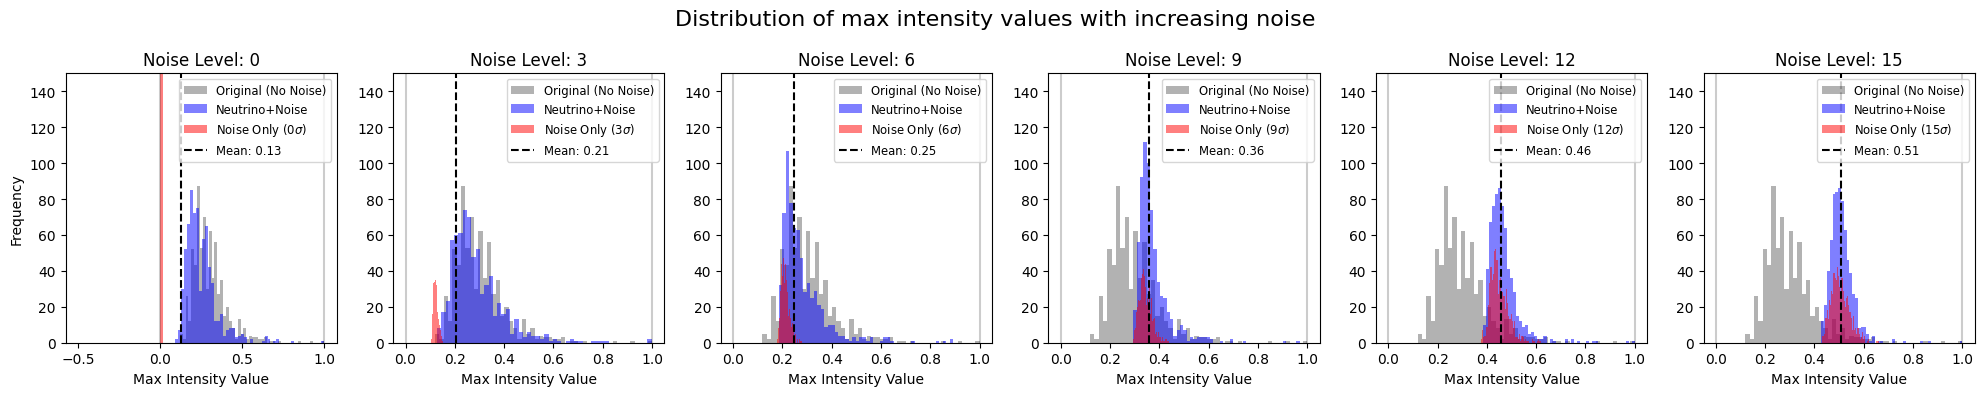

In [ ]:
# Define noise levels to iterate through
noise_levels = np.arange(0, 16, 3)

fig, ax = plt.subplots(1, 6, figsize=(20, 4))
fig.suptitle('Distribution of max intensity values with increasing noise', fontsize=16)

# 1. Generate a baseline "Original" set (Pure Neutrino, Noise=0)
# We only need to do this once, but we need it to compare against the noisy versions.
X_base, y_base, _, _, _, _ = prepare_training_data(
    lar_images, num_of_images=2000, overlaid_noise=True, noise_range=[0, 0]
)
# Extract max intensity for pure neutrinos (Label 1)
original_dist = max_intensity_per_image(X_base[y_base == 1])

# 2. Loop through noise levels
for i, j in enumerate(noise_levels):
    # Generate data for this specific noise level
    X_train, y_train, _, _, _, _ = prepare_training_data(
        lar_images, num_of_images=2000, overlaid_noise=True, noise_range=[j, j]
    )

    # Separate Neutrinos (Label 1) and Noise (Label 0) using boolean indexing
    neutrino_dist = max_intensity_per_image(X_train[y_train == 1])
    noise_dist = max_intensity_per_image(X_train[y_train == 0])
    
    # Combine for the global mean calculation
    all_dist = np.concatenate([neutrino_dist, noise_dist])

    # Plotting
    ax[i].hist(original_dist, bins=50, color='k', label='Original (No Noise)', alpha=0.3)
    ax[i].hist(neutrino_dist, bins=50, color='b', label='Neutrino+Noise', alpha=0.5)
    ax[i].hist(noise_dist, bins=50, color='r', label=f'Noise Only ({j}$\sigma$)', alpha=0.5)
    
    # Formatting
    ax[i].set_title(f'Noise Level: {j}')
    ax[i].set_xlabel('Max Intensity Value')
    ax[i].set_ylim(0, 150) # Adjust based on your data volume
    
    # Vertical lines for bounds and mean
    ax[i].axvline(x=0, c='k', ls='-', alpha=0.2)
    ax[i].axvline(x=1, c='k', ls='-', alpha=0.2)
    ax[i].axvline(np.mean(all_dist), c='k', ls='--', label=f'Mean: {np.mean(all_dist):.2f}')

    if i == 0:
        ax[i].set_ylabel('Frequency')
        ax[i].legend(loc='upper right', fontsize='small')
    else:
        ax[i].legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

These plots visualise what happens when noise is added to the images. As we approach noise levels > 6, the majority of original dataset peaks are already eclipsed by the peak values of noise, which can lead to false positives or feature extraction failure. 

# Extension 1: Radioactive Noise

In the LArTPC, noise can also come from the detector medium itself. Argon naturally contains beta-emitting radioisotopes like Argon-39, as well as contaminants like Chlorine-39 and Sulfur-35. Due to their low energy, they travel very short distances in the liquid before stopping, creating isolated "blobs" of charge.

Each blob will be modelled as a 2D gaussian, with a random position, size and intensity. Their maximum intensity will correlate to around 0.565 MeV, as this is the Q-value (maximum energy) of Argon-39, the most prominent radioisotope, although some variability will be present.

In [ ]:
def radioactive_noise(image_shape, max_blobs_per_image, blob_noise_level):
    """
    Generates a dataset of images containing random Gaussian 'blob' noise, simulating 
    radioactive decay backgrounds (e.g., Ar-39) in a particle detector.

    Args:
        image_shape (tuple): The shape of the output dataset (num_images, height, width).
                             Example: (100, 100, 100) for 100 images of size 100x100.
        max_blobs_per_image (int): The upper limit of noise blobs to add per image. 
                                   The actual number is randomized between 0 and this value.
        blob_noise_level (float): The maximum intensity (amplitude) of the blobs. 
                                  Corresponds to the 'spread' or energy range.

    Returns:
        np.ndarray: An array of shape `image_shape` containing the generated noise images.
    """
    num_images, height, width = image_shape
    noise_dataset = np.zeros(image_shape)

    # Optimization: Pre-compute the coordinate grid once 
    # instead of re-calculating it for every single blob.
    yy, xx = np.mgrid[:height, :width]

    for i in range(num_images):
        # Determine how many blobs to add for this specific image
        if max_blobs_per_image > 0:
            num_blobs = np.random.randint(0, max_blobs_per_image)
        else:
            num_blobs = 0

        current_image = np.zeros((height, width))

        for _ in range(num_blobs):
            # Randomize blob properties
            x0 = np.random.randint(0, width)
            y0 = np.random.randint(0, height)
            
            # Sigma (size) of the blob. 
            # Changed low bound to 0.1 to avoid division by zero errors if size is 0.
            sigma = np.random.uniform(0.1, 5.0) 
            
            # Amplitude (Height/Intensity)
            # Sampled from uniform distribution up to 'blob_noise_level'
            amplitude = np.random.uniform(0, blob_noise_level)

            # Generate the 2D Gaussian
            # Formula: A * exp( - (r^2) / (2*sigma^2) )
            gaussian = amplitude * np.exp(-((xx - x0)**2 + (yy - y0)**2) / (2 * sigma**2))

            # Accumulate the blob onto the image
            current_image += gaussian

        # Clip values below zero
        current_image = np.clip(current_image, 0, None)
        noise_dataset[i] = current_image

    return noise_dataset

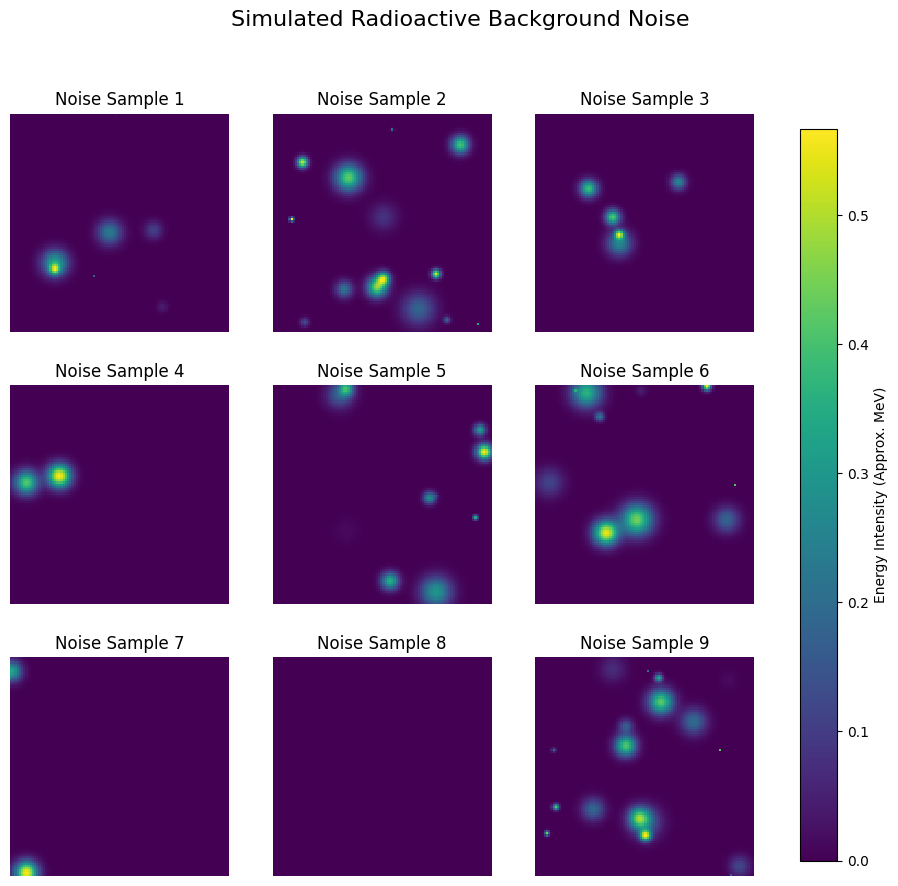

In [ ]:
# Using the realistic parameters: Max 20 blobs, Max intensity 0.5 MeV
noise_samples = radioactive_noise(
    image_shape=(9, 100, 100), 
    max_blobs_per_image=20, 
    blob_noise_level=0.5
)

# Create Figure with 3x3 subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

# Loop and Plot
for i, ax in enumerate(axes.flat):
    # Plot the image (using default Viridis colormap to match your reference)
    im = ax.imshow(noise_samples[i], origin='lower', interpolation='nearest')
    
    # Stylization
    ax.set_title(f'Noise Sample {i+1}')
    ax.axis('off')

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label('Energy Intensity (Approx. MeV)')

fig.suptitle('Simulated Radioactive Background Noise', fontsize=16)
plt.show()

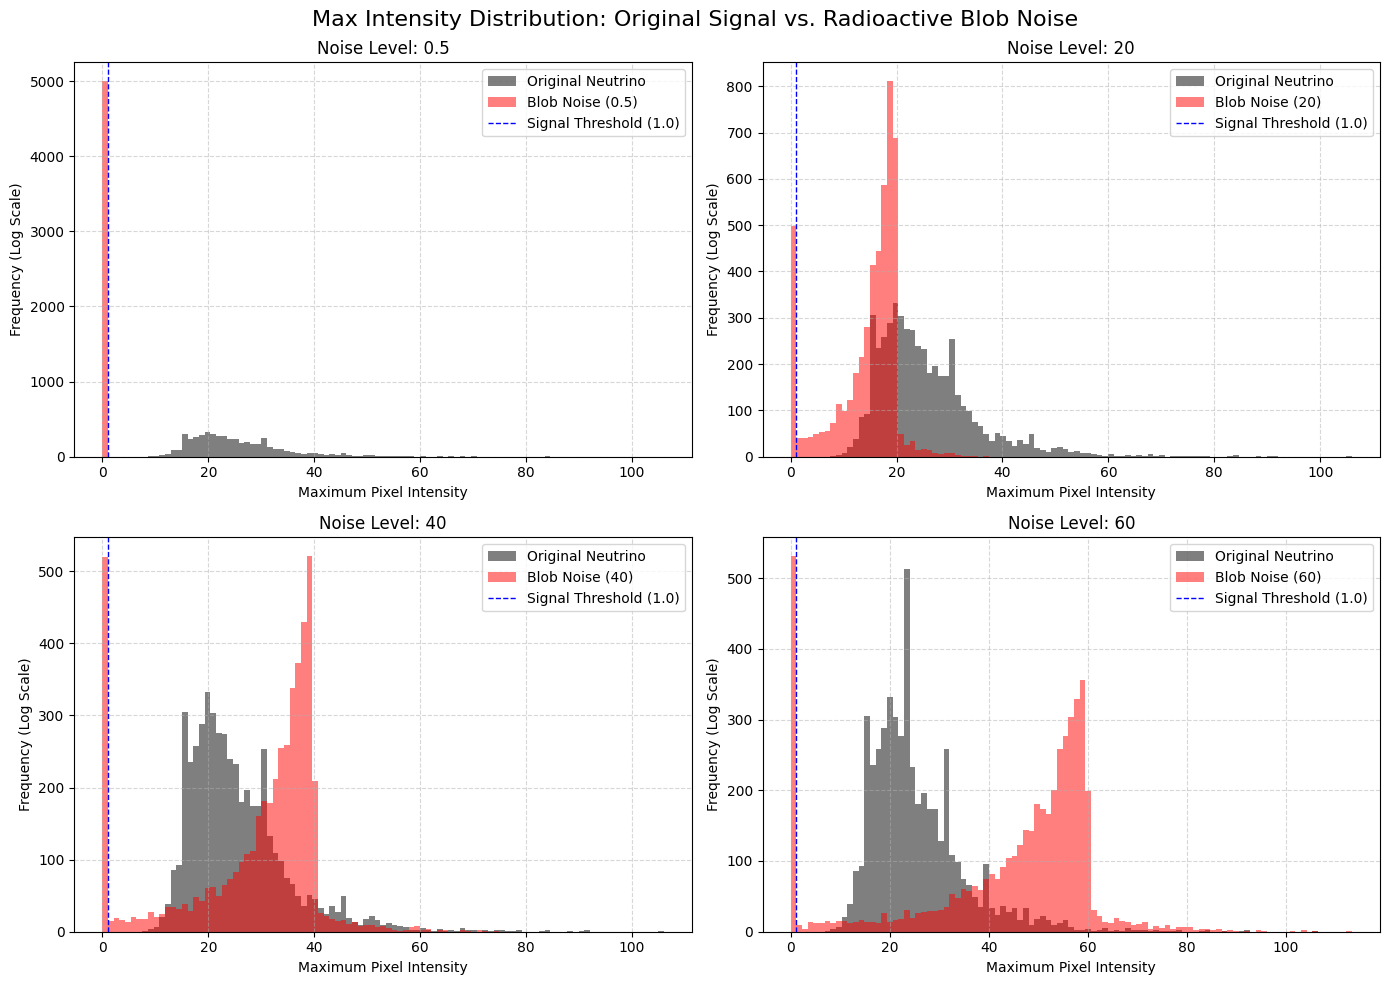

In [ ]:
# Define the specific noise levels to test
noise_levels_to_test = [0.5, 20, 40, 60]
num_samples_for_hist = 5000  # Number of images to generate for good statistics
max_blobs = 10 # Keeping consistent with your snippet suggestion

images_max_vals = max_intensity_per_image(lar_images[:num_samples_for_hist])

# Begin figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Max Intensity Distribution: Original Signal vs. Radioactive Blob Noise', fontsize=16, y=0.98)

# Flatten axes array for easy iteration
ax_flat = axes.flatten()

# 3. Loop through noise levels and plot
for i, level in enumerate(noise_levels_to_test):
    ax = ax_flat[i]
    
    # Generate specific noise dataset
    noise_imgs = radioactive_noise(
        image_shape=(num_samples_for_hist, 100, 100),
        max_blobs_per_image=max_blobs,
        blob_noise_level=level
    )
    
    # Calculate max intensities for noise
    noise_max_vals = max_intensity_per_image(noise_imgs)
    
    # Find overall max value for binning range to ensure histograms share x-axis scale
    overall_max = max(np.max(images_max_vals), np.max(noise_max_vals))
    bins = np.linspace(0, overall_max, 100)

    # Plot Original Neutrino Data (Grey baseline)
    ax.hist(images_max_vals, bins=bins, color='k', alpha=0.5, label='Original Neutrino')
    
    # Plot Generated Noise Data (Red comparison)
    ax.hist(noise_max_vals, bins=bins, color='r', alpha=0.5, label=f'Blob Noise ({level})')
    
    # Reference line at 1.0 (typical max signal intensity)
    ax.axvline(x=1.0, color='b', linestyle='--', linewidth=1, label='Signal Threshold (1.0)')

    # Stylization
    ax.set_title(f'Noise Level: {level}')
    ax.set_xlabel('Maximum Pixel Intensity')
    ax.set_ylabel('Frequency (Log Scale)')
    #ax.set_yscale('log')
    ax.grid(True, which='both', linestyle='--', alpha=0.5)
    ax.legend()

plt.tight_layout()
plt.show()

#### Observations

It seems like at a noise level > 40, the blob peaks begin to eclipse the original dataset values. As such, it might seem like a noise level of 40 would be a good choice to train our models on. However, it must also be considered that our Gaussian blobs are small blob peaks scattered throughout the image, and therefore the intensity may not matter a great deal if our model is capable of proper feature extraction (i.e. intense blob $\ne$ neutrino track). Thus, the determining factors may be more about the blob count (smothering the image) and also the blob radius. 

Since increasing the blob count to obscene levels (smothering the entire image) as well as making the blobs unrealistically large wouldn't be realistic, we will simply crank up the noise levels and see whether it affects our model at all.

### Training our Task 4 Model

In [ ]:
def radioactive_training_data(images, num_of_images, overlaid_noise, noise_range, 
                          max_blobs=20, trn_val_tst_ratio=[0.7, 0.15, 0.15]):
    '''
    Generates training, validation and testing datasets for CNN binary classification.
    Half of the images are neutrinoless (label 0) and half contain neutrinos (label 1).
    Radioactive blob noise is applied instead of simple Gaussian noise.

    Inputs:
    - images: Neutrino image dataset of shape (num_images, height, width)
    - num_of_images: Total number of output images (balanced 50/50 split)
    - overlaid_noise: Boolean. If True, adds noise to the neutrino images too.
    - noise_range: Tuple/List [low, high] for the random intensity (amplitude) of the blobs.
    - max_blobs: Maximum number of radioactive blobs per image (default: 20).
    - trn_val_tst_ratio: Split ratios for [train, val, test].

    Outputs:
    - X_train, y_train, X_val, y_val, X_test, y_test
    '''
    num_per_type = int(num_of_images / 2)
    height, width = images.shape[1], images.shape[2]

    # Shuffle and select base neutrino images
    shuffled_indices = np.random.permutation(len(images))
    neutrino_images = images[shuffled_indices][:num_per_type].copy()
    neutrino_labels = np.ones(num_per_type, dtype=int)
    
    # noise images
    noise_only_images = np.zeros((num_per_type, height, width))
    noise_only_labels = np.zeros(num_per_type, dtype=int)

    # Process Neutrino Images (Label 1)
    if overlaid_noise:
        for i in range(num_per_type):
            # Randomize noise intensity for this specific image
            current_noise_level = random.uniform(noise_range[0], noise_range[1])
            
            # Generate 1 noise image with these parameters
            noise_layer = radioactive_noise(
                image_shape=(1, height, width), 
                max_blobs_per_image=max_blobs, 
                blob_noise_level=current_noise_level
            )[0]
            
            neutrino_images[i] = neutrino_images[i] + noise_layer

    # Process Noise-Only Images (Label 0)
    for i in range(num_per_type):
        # Randomize noise intensity for this specific image
        current_noise_level = random.uniform(noise_range[0], noise_range[1])
        
        # Generate pure noise image
        noise_only_images[i] = radioactive_noise(
            image_shape=(1, height, width), 
            max_blobs_per_image=max_blobs, 
            blob_noise_level=current_noise_level
        )[0]

    # Combine and Shuffle
    all_images = np.concatenate([neutrino_images, noise_only_images], axis=0)
    all_labels = np.concatenate([neutrino_labels, noise_only_labels], axis=0)

    # normalise
    all_images_normalized = normalise_intensity(all_images)

    # shuffle again because why not
    num_total = all_images_normalized.shape[0]
    shuffle_indices = np.random.permutation(num_total)
    X_shuffled = all_images_normalized[shuffle_indices]
    y_shuffled = all_labels[shuffle_indices]

    # Split Data
    train_end = int(trn_val_tst_ratio[0] * num_total)
    val_end = train_end + int(trn_val_tst_ratio[1] * num_total)

    X_train = X_shuffled[:train_end]
    y_train = y_shuffled[:train_end]

    X_val = X_shuffled[train_end:val_end]
    y_val = y_shuffled[train_end:val_end]

    X_test = X_shuffled[val_end:]
    y_test = y_shuffled[val_end:]

    # Add Channel Dimension (N, H, W, 1)
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    return X_train, y_train, X_val, y_val, X_test, y_test

Visualisation of noise overlaid onto neutrino images:

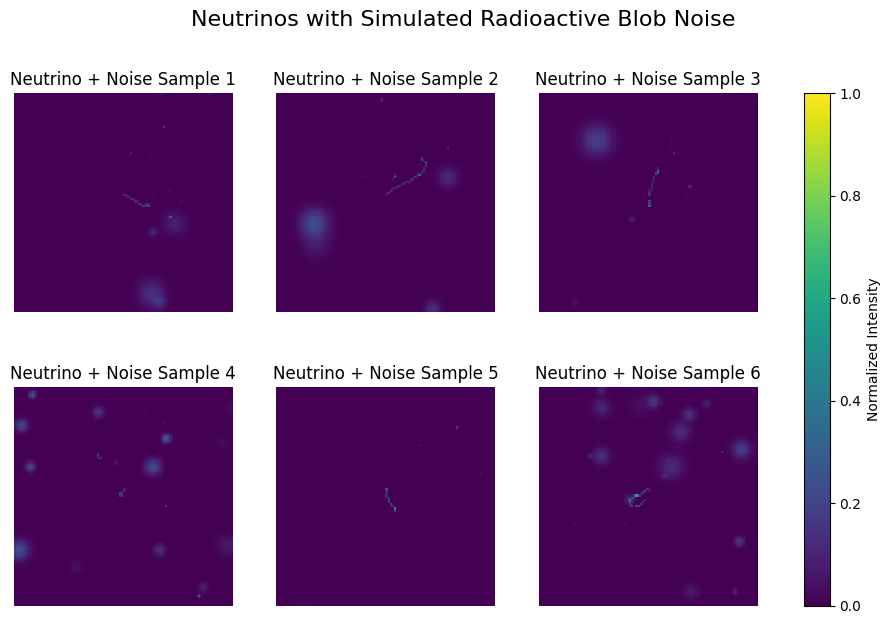

In [ ]:
# Generate Data
X_train, y_train, _, _, _, _ = radioactive_training_data(
    images=lar_images,
    num_of_images=200,         
    overlaid_noise=True,      
    noise_range=[0, 40],    
    max_blobs=20,
)

# Filter: Select only Neutrino samples (Label == 1)
# note: also squeezed from (N, 100, 100, 1) --> (N, 100, 100) for plotting.
neutrino_samples = np.squeeze(X_train[y_train == 1])[:6]

# Plot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

im = None # Placeholder 
for i, ax in enumerate(axes.flat):
    im = ax.imshow(neutrino_samples[i], origin='lower', interpolation='nearest', vmin=0, vmax=1)
    
    # Stylization
    ax.set_title(f'Neutrino + Noise Sample {i+1}')
    ax.axis('off')

# Shared colorbar and title
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
cbar.set_label('Normalized Intensity')

fig.suptitle('Neutrinos with Simulated Radioactive Blob Noise', fontsize=16)
plt.show()

Once again, 

In [ ]:
# Create model
task4_model = build_resnet_mini()   

# Create Training, Validation, Testing Datasets
X_train, y_train, X_val, y_val, X_test, y_test = radioactive_training_data(
    lar_images,
    num_of_images=10000,
    overlaid_noise=True,
    noise_range=[0,70],
    max_blobs=20
)

# Train model
print(f'Training Task 4 Model:')
history = task4_model.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val,y_val),
    verbose=1
)

Training Task 4 Model:
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 129s 573ms/step - accuracy: 0.9347 - loss: 0.1620 - val_accuracy: 0.4940 - val_loss: 2.8880
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 567ms/step - accuracy: 0.9760 - loss: 0.0714 - val_accuracy: 0.4940 - val_loss: 4.3028
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 125s 570ms/step - accuracy: 0.9909 - loss: 0.0338 - val_accuracy: 0.9607 - val_loss: 0.1384
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 568ms/step - accuracy: 0.9873 - loss: 0.0394 - val_accuracy: 0.9947 - val_loss: 0.0170
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 567ms/step - accuracy: 0.9917 - loss: 0.0311 - val_accuracy: 0.9967 - val_loss: 0.0122
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 567ms/step - accuracy: 0.9964 - loss: 0.0149 - val_accuracy: 0.5067 - val_loss: 4.8403
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 125s 569ms/step - accuracy: 0.9964 - loss: 0.0124 - val_accuracy: 0.9987 - val_loss: 0.0047
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 567ms/st

Testing Task 4 Model:
Test Loss: 0.0103
Test Accuracy: 0.9973
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step
Classification Report:
              precision    recall  f1-score   support

       Noise       0.99      1.00      1.00       747
    Neutrino       1.00      0.99      1.00       753

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



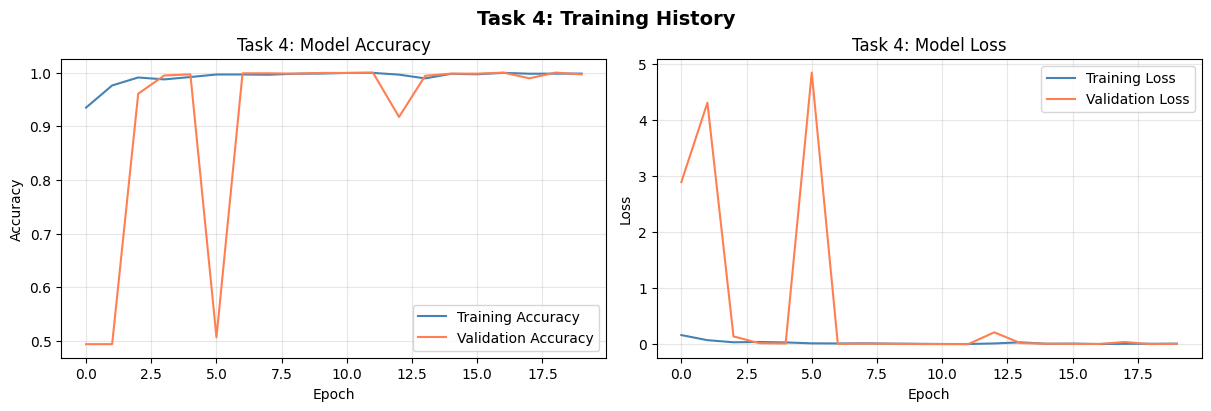

In [ ]:
# Evaluate on test data
print(f'Testing Task 4 Model:')
test_loss, test_accuracy = task4_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = task4_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print(f'Classification Report:')
print(metrics.classification_report(y_test, y_pred, target_names=['Noise', 'Neutrino']))

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig.suptitle('Task 4: Training History', fontsize=14, weight='bold')

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='steelblue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='coral')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Task 4: Model Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', color='steelblue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='coral')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Task 4: Model Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.show()

#### Model vs. Increasing Radiation Intensity

NL 0 TEST:
Test Accuracy: 0.9987
Test Loss: 0.0029
NL 20 TEST:
Test Accuracy: 0.9993
Test Loss: 0.0023
NL 40 TEST:
Test Accuracy: 0.9980
Test Loss: 0.0081
NL 60 TEST:
Test Accuracy: 0.9933
Test Loss: 0.0164
NL 80 TEST:
Test Accuracy: 0.9907
Test Loss: 0.0254
NL 100 TEST:
Test Accuracy: 0.9753
Test Loss: 0.0944


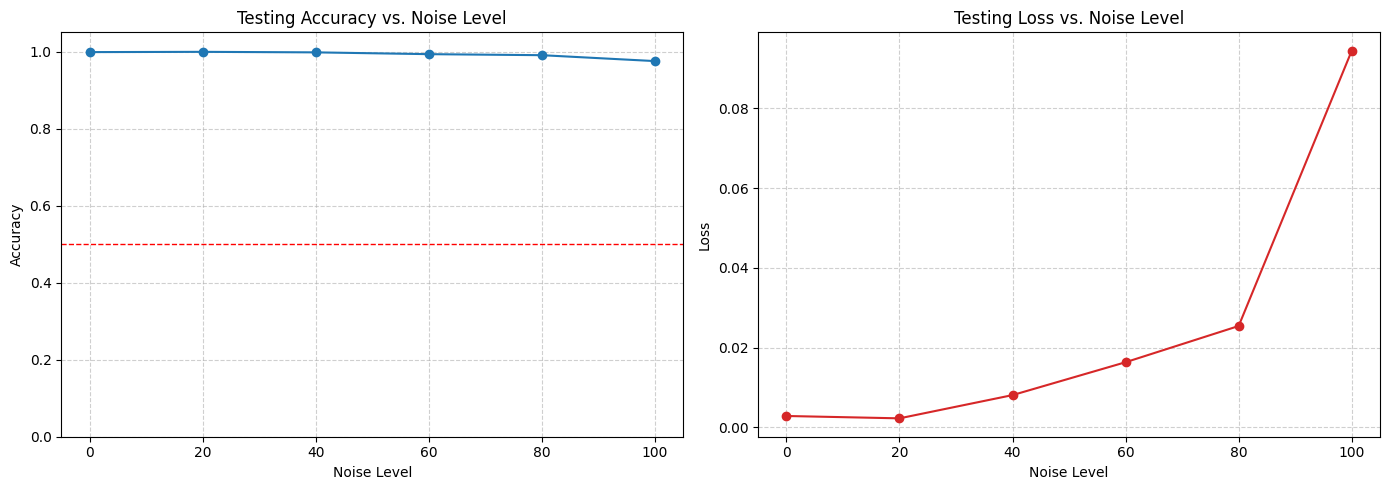

In [ ]:
# Testing Noise Ranges from 0-100:
noise_range=[0,100]

# Store the testing loss and accuracies for graphing
noise_record=[]
test_accuracy_record=[]
test_loss_record=[]

# Loop through each noise range with step 2
for i in range(noise_range[0],noise_range[1]+20,20):
    # Generate testing data for each noise level
    X_train, y_train, X_val, y_val, X_test, y_test = radioactive_training_data(
    lar_images,
    num_of_images=10000,
    overlaid_noise=True,
    noise_range=[i,i]
    )
    # Test model on testing datasets for noise at this level
    print(f'NL {i} TEST:')
    test_loss, test_accuracy = task4_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")    
    print(f"Test Loss: {test_loss:.4f}")

    # Append the loss, accuracy record lists
    noise_record.append(i)
    test_accuracy_record.append(test_accuracy)
    test_loss_record.append(test_loss)

# Create a figure with 2 subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Accuracy
ax1.plot(noise_record, test_accuracy_record, marker='o', color='tab:blue', label='Accuracy')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
ax1.set_title('Testing Accuracy vs. Noise Level')
ax1.set_xlabel('Noise Level')
ax1.set_ylabel('Accuracy')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylim(0, 1.05)  # Set y-axis to range from 0 to 1 for clarity

# Subplot 2: Loss
ax2.plot(noise_record, test_loss_record, marker='o', color='tab:red', label='Loss')
ax2.set_title('Testing Loss vs. Noise Level')
ax2.set_xlabel('Noise Level')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to prevent overlap and display
plt.tight_layout()
plt.show()


#### Model vs. Increasing Blob Count



NL 20 TEST:
Test Accuracy: 0.9973
Test Loss: 0.0084
NL 40 TEST:
Test Accuracy: 0.9967
Test Loss: 0.0121
NL 60 TEST:
Test Accuracy: 0.9833
Test Loss: 0.0485
NL 80 TEST:
Test Accuracy: 0.9793
Test Loss: 0.0550
NL 100 TEST:
Test Accuracy: 0.9700
Test Loss: 0.0832
NL 120 TEST:
Test Accuracy: 0.9507
Test Loss: 0.1242


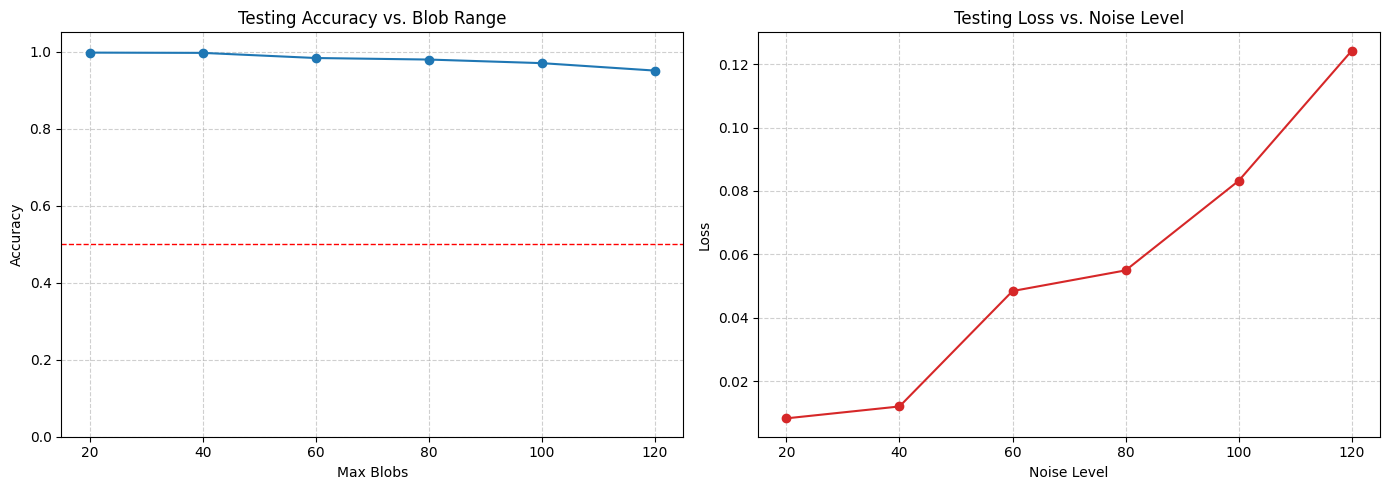

In [ ]:
# Testing Max Blob Ranges from 20 (normal) to 100 (extreme):
blob_range=[20,120]

# Store the testing loss and accuracies for graphing
max_blob_record=[]
test_accuracy_record=[]
test_loss_record=[]

# Loop through each blob range with step 20
for i in range(blob_range[0],blob_range[1]+20,20):
    # Generate testing data for each blob level
    X_train, y_train, X_val, y_val, X_test, y_test = radioactive_training_data(
    lar_images,
    num_of_images=10000,
    overlaid_noise=True,
    noise_range=[40,40],
    max_blobs=i
    )
    # Test model on testing datasets for blobs at this level
    print(f'NL {i} TEST:')
    test_loss, test_accuracy = task4_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")    
    print(f"Test Loss: {test_loss:.4f}")

    # Append the loss, accuracy record lists
    max_blob_record.append(i)
    test_accuracy_record.append(test_accuracy)
    test_loss_record.append(test_loss)

# Create a figure with 2 subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Subplot 1: Accuracy
ax1.plot(max_blob_record, test_accuracy_record, marker='o', color='tab:blue', label='Accuracy')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
ax1.set_title('Testing Accuracy vs. Blob Range')
ax1.set_xlabel('Max Blobs')
ax1.set_ylabel('Accuracy')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylim(0, 1.05)  # Set y-axis to range from 0 to 1 for clarity

# Subplot 2: Loss
ax2.plot(max_blob_record, test_loss_record, marker='o', color='tab:red', label='Loss')
ax2.set_title('Testing Loss vs. Noise Level')
ax2.set_xlabel('Noise Level')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to prevent overlap and display
plt.tight_layout()
plt.show()


# Extension 2: Electron & Neutrino Energy

First, we need to correctly extract the electron and neutrino energies from the metadata. The neutrino energy is easy to extract via `metadata[:1]` (first column of every row). However, the electron energy is more complicated. A description of the metadata is given below:
| Column | Description |
| ----------- | ----------- |
| 0 | Row number |
| 1 | Neutrino Energy (MeV) |
| 2 | Initial state particles (always 2) |
| 3 | Final state particles (varies) |
| 4-8 | Initial Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 9-13 | Initial Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 14-18 | Final Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 19-23 | Final Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| $\vdots$ | Final Particle N: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 59-63 | Final Particle 10: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |

Where the PDG code is is a unique integer identifier from the Particle Data Group, used in particle physics to label different particles (like quarks, leptons, bosons) for computer simulations. Electrons have code 11, and are typically created in charged-current (CC) processes, where the neutrino is turned into its charged partner (i.e. eletron-neutrino νe turns into an electron e−). As such, we expect to see electrons in the final particle columns 14-59 with step 4. 

But lets first inspect the metadata to verify where electrons are actually placed. 


In [20]:
possible_columns = [4, 9, 14, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59]

# Initialize a dictionary with 0 for each column
# Structure: {4: 0, 9: 0, 14: 0, ...}
column_counts = {col: 0 for col in possible_columns}

# Loop through each target column
for column in possible_columns:
    for i in range(len(metadata)):
        # check if value at this row and column is 11 for electron
        if metadata[i,column] == 11:
            column_counts[column] += 1

print(column_counts)

{4: 0, 9: 0, 14: 10000, 19: 0, 23: 0, 27: 0, 31: 0, 35: 0, 39: 0, 43: 0, 47: 0, 51: 0, 55: 0, 59: 0}


Although we expected electrons as final particles, it is surprising to see all 10,000 of them in column 14, i.e. final particle #1. With this knowledge, we can then easily extract the electron energy from column 15, as for each particle they are described in 5 columns:

Column:<br>
14 - PDG code (electron)<br>
15 - Total Energy (MeV)<br>
16 - $p_x$<br>
17 - $p_y$<br>
18 - $p_z$<br>

Now we can extract both the electron and neutrino energies easily:

In [7]:
electron_energy = metadata[:,15]
neutrino_energy = metadata[:,1]

### Generating Training Datasets

In [6]:
def energy_training_data(images, energies, trn_val_tst_ratio=[0.7, 0.15, 0.15]):
    '''
    Generates training, validation, and testing datasets for CNN regression to predict electron or neutrino energy.
    Selects a subset of real neutrino images, normalizes pixel intensity, and normalizes energy targets.

    Inputs:
    - images: Neutrino image dataset of shape (num_images, height, width)
    - energies: Array of electron or neutrino energies corresponding to 'images' (num_images,)
    - trn_val_tst_ratio: Split ratios for [train, val, test]

    Outputs:
    - X_train, y_train: Training images and normalized energy labels
    - X_val, y_val: Validation images and normalized energy labels
    - X_test, y_test: Test images and normalized energy labels
    '''

    # Shuffle indices
    shuffled_indices = np.random.permutation(len(images))

    X_data = normalise_intensity(images[shuffled_indices])     # neutrino images
    y_data = normalise_intensity(energies[shuffled_indices])   # neutrino energy labels

    # Split Data
    num_total = len(X_data)
    train_end = int(trn_val_tst_ratio[0] * num_total)
    val_end = train_end + int(trn_val_tst_ratio[1] * num_total)

    X_train = X_data[:train_end]
    y_train = y_data[:train_end]

    X_val = X_data[train_end:val_end]
    y_val = y_data[train_end:val_end]

    X_test = X_data[val_end:]
    y_test = y_data[val_end:]

    # Add channel dimension: (N, H, W) -> (N, H, W, 1)
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    return X_train, y_train, X_val, y_val, X_test, y_test

### Verifying Training Data

Let's first generate a batch of data and verify that it's valid:

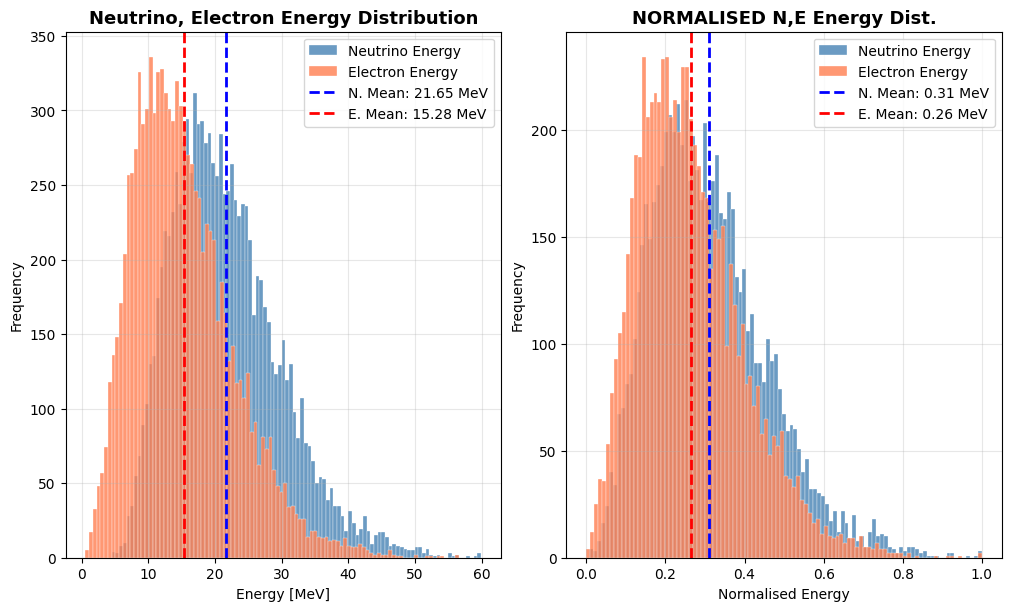

In [8]:
# Normalised training, validation, and test datasets
X_train_neutrino, y_train_neutrino, X_val_neutrino, y_val_neutrino, X_test_neutrino, y_test_neutrino = energy_training_data(
    lar_images,
    neutrino_energy,
)
# Normalised training, validation, and test datasets
X_train_electron, y_train_electron, X_val_electron, y_val_electron, X_test_electron, y_test_electron = energy_training_data(
    lar_images,
    electron_energy,
)

# Create figure with 3 subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True)

# Plot overlapping histograms with transparency
ax[0].hist(neutrino_energy, bins=100, color='steelblue', alpha=0.8,
           label='Neutrino Energy', edgecolor='white', linewidth=0.3)
ax[0].hist(electron_energy, bins=100, color='coral', alpha=0.8,
           label='Electron Energy', edgecolor='white', linewidth=0.3)

# Add mean lines
ax[0].axvline(np.mean(neutrino_energy), c='b', ls='--', lw=2,
              label=f'N. Mean: {np.mean(neutrino_energy):.2f} MeV')
ax[0].axvline(np.mean(electron_energy), c='r', ls='--', lw=2,
              label=f'E. Mean: {np.mean(electron_energy):.2f} MeV')

ax[0].set_title('Neutrino, Electron Energy Distribution', fontsize=13, weight='bold')
ax[0].set_xlabel('Energy [MeV]')
ax[0].set_ylabel('Frequency')
ax[0].legend()
ax[0].grid(alpha=0.3)

# Plot overlapping histograms with transparency
ax[1].hist(y_train_neutrino, bins=100, color='steelblue', alpha=0.8,
           label='Neutrino Energy', edgecolor='white', linewidth=0.3)
ax[1].hist(y_train_electron, bins=100, color='coral', alpha=0.8,
           label='Electron Energy', edgecolor='white', linewidth=0.3)

# Add mean lines
ax[1].axvline(np.mean(y_train_neutrino), c='b', ls='--', lw=2,
              label=f'N. Mean: {np.mean(y_train_neutrino):.2f} MeV')
ax[1].axvline(np.mean(y_train_electron), c='r', ls='--', lw=2,
              label=f'E. Mean: {np.mean(y_train_electron):.2f} MeV')

ax[1].set_title('NORMALISED N,E Energy Dist.', fontsize=13, weight='bold')
ax[1].set_xlabel('Normalised Energy')
ax[1].set_ylabel('Frequency')
ax[1].legend()
ax[1].grid(alpha=0.3)

plt.show()

### Training the Model

First we train it for neutrinos:

In [26]:
# Create energy model
task5_model_neutrino = build_resnet_mini(lossmode='mean_squared_error',metric='mae')   

# Train model
print(f'Training Task 5 Model:')
history = task5_model_neutrino.fit(
    X_train_neutrino,y_train_neutrino,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_neutrino,y_val_neutrino),
    verbose=1
)


Training Task 5 Model:
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 127s 568ms/step - loss: 0.0195 - mae: 0.1043 - val_loss: 0.1015 - val_mae: 0.2819
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 126s 575ms/step - loss: 0.0110 - mae: 0.0799 - val_loss: 0.1118 - val_mae: 0.3000
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 123s 563ms/step - loss: 0.0095 - mae: 0.0747 - val_loss: 0.0236 - val_mae: 0.1246
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 121s 552ms/step - loss: 0.0090 - mae: 0.0723 - val_loss: 0.0692 - val_mae: 0.2368
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 122s 557ms/step - loss: 0.0087 - mae: 0.0712 - val_loss: 0.0085 - val_mae: 0.0618
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 125s 567ms/step - loss: 0.0087 - mae: 0.0712 - val_loss: 0.0492 - val_mae: 0.2009
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 564ms/step - loss: 0.0087 - mae: 0.0709 - val_loss: 0.0071 - val_mae: 0.0643
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 124s 568ms/step - loss: 0.0084 - mae: 0.0698 - val_loss: 0.0076 - val_mae: 0.0631
E

Just by looking at the training results, it is evident that the model demonstrates capacity to learn the training data, with the training mean absolute error (MAE) steadily decreasing to ~0.0621 by epoch 20, corresponding to an average MeV error of:
$$(59.93-4.49 \textup{MeV})*0.0621 = 3.44 MeV$$

Which is a great value for larger energies at ~6% relative error, but not ideal for lower neutrino energies with up to ~75% relative error. Our mean neutrino energy is 21.65 MeV, so our model on average will be hovering around a 15.88% relative error. Let's see if we can reduce this using Keras Tuner to find an optimal set of training parameters.


I have written a Keras Tunable version of our model below to identify the strongest combination of our three parameters:
- Dropout
- Learning rate
- Dense layer size

**Why `kt.randomsearch`?**<br>
Since we aren't training the model for egregious amounts of time, `randomsearch` was selected over 'smarter' methods like Bayesian Optimisation and Hyperband as they require far higher computation time. BO requires larger sample sizes to develop a hyperparameter surface for cross-parameter optimisation. Hyperband tries out all of the possible combinations and does continuous elimination. As the possible combinations of our parameters isn't significantly large, I decided to use `randomsearch` effectively as an automated FOR loop to help us find stronger parameters than are existing.

In this model, I've also added (since our model is getting a bit beefier):
- `Sigmoid` -> `Linear` Output: Allowing for continuous output values. This might actually be the biggest difference-maker
- `ReLU` -> `LeakyReLU`: Allows small negative gradients, which could improve fine adjustments in the model
- `he_normal` initialiser -> tuned for networks using ReLU and prevents vanishing signals in deep networks
- Dense layer in head -> Stronger feature understanding



In [9]:
def residual_block_l2_reg(x, filters, stride,activation='relu',l2_reg=1e-4):
    """
    A standard ResNet Identity Block.
    
    Args:
        x: Input tensor
        filters: Number of filters (feature maps)
        stride: Stride size (used for downsampling)
        activation: Activation function to be used. Select from 'leaky_relu','swish','relu'.
        l2_reg: L2 regularization factor
    """
    shortcut = x
    
    # First Conv Layer
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = get_activation_layer(x,type_name=activation)
    
    # Second Conv Layer
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False,
                    kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    
    # Shortcut Adjustment
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Add()([x, shortcut])
    x = get_activation_layer(x,type_name=activation)
    return x

In [ ]:
def tunable_regression_model(hp):
    """
    Builds the ResNet regression model with hyperparameters accessible to Keras Tuner.
    """
    # Hyperparameters to tune:

    # Filters
    hp_filter_startvalue = hp.Choice('filter_startvalue', values=[16,32,64])
    filter_list = [hp_filter_startvalue*2**i for i in range(4)]   # if first filter is 16, then next ones are 32, 64, 128

    # Activation function: Inside hidden Conv2D blocks
    hp_activation_hidden = hp.Choice('activation_fn_hidden', values=['relu', 'leaky_relu', 'swish'])

    # Residual blocks per stack
    hp_blocks_per_stack = hp.Int('blocks_per_stack)',min_value=1,max_value=3,step=1)

    # L2 Regularisation
    hp_l2_reg = hp.Float('l2_reg',min_value=1e-6,max_value=1e-3,sampling='log')

    # Dropout Rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)

    # Dense Layer Size
    hp_dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    
    # Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    # Define model architecture as usual
    inputs = Input(shape=(100, 100, 1))
    
    # Stem
    x = layers.Conv2D(hp_filter_startvalue, kernel_size=3, strides=1, padding='same', 
                      use_bias=False, kernel_initializer='he_normal', kernel_regularizer = regularizers.l2(hp_l2_reg))(inputs)
    x = layers.BatchNormalization()(x)
    x = get_activation_layer(x,hp_activation_hidden)

    # Residual block stacks. Number of stacks is determined by length of filter_list
    # Loops to identify the stride required for each block
    for stack_no, filters in enumerate(filter_list):
        # First block in a stack might stride, others don't
        stride = 2 if stack_no > 0 else 1 

        # Add dynamic number of blocks per stage
        for block_no in range(hp_blocks_per_stack):
            # Only stride on the very first block of the stage (if needed)
            current_stride = stride if block_no == 0 else 1

            # Create a residual block using current filters, stride, activation function, regularization rate
            x = residual_block_l2_reg(x, filters=filters, stride=current_stride, 
                           activation=hp_activation_hidden, l2_reg=hp_l2_reg)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    
    # Tunable Dense Layer
    x = layers.Dense(hp_dense_units, kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(hp_l2_reg))(x)
    x = get_activation_layer(x,hp_activation_hidden)
    
    # Tunable Dropout
    x = layers.Dropout(hp_dropout)(x)
    
    outputs = layers.Dense(1, activation='linear',dtype='float32')(x)

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile with Tunable Learning Rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

'''
# RandomSearch variant
tuner = kt.RandomSearch(
    tunable_regression_model,
    objective='val_mae',      # We want to minimize Validation MAE
    max_trials=20,            # Total number of combinations to try
    executions_per_trial=1,   # Run each trial once
    directory='tuner_results',
    project_name='neutrino_energy_opt_rs' #rs=randomsearch
)
'''
'''
# Hyperband variant
tuner = kt.Hyperband(
    tunable_regression_model,
    objective='val_mae',
    max_epochs=20,            # Max epochs for the absolute best model
    factor=3,                 # Reduction factor 
    hyperband_iterations=1,   # How many times to run the full algorithm
    directory='tuner_results',
    project_name='neutrino_energy_opt_hb' #hb=hyperband
)
'''

# Bayesian Optimisation variant (if you want to run your computer all day!!!)
tuner = kt.BayesianOptimization(
    tunable_regression_model,
    objective='val_mae',         
    max_trials=100,              
    num_initial_points=10,        # Run 10 random trials first to "seed" our model
    alpha=0.0001,                
    beta=2.6,                  
    directory='tuner_results',
    project_name='neutrino_energy_opt_bo', #bo=bayesian optimisation
)

# Search 
print("Starting Hyperparameter Search...")
tuner.search(
    X_train_neutrino,y_train_neutrino, 
    epochs=30, 
    validation_data=(X_val_neutrino, y_val_neutrino),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)], 
    verbose=1
)

# Extract best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the final best model
task5_neutrino_optimised = tuner.hypermodel.build(best_hps)

In [ ]:
print(f"""
Task 5: Regression Model Hyperparameter search results:
Optimal Filter start value: {best_hps.get('filter_startvalue')}
Optimal Hidden Activation Function:     {best_hps.get('activation_fn_hidden')}
Optimal Blocks per stack:          {best_hps.get('blocks_per_stack)')}
Optimal L2 Regularisation rate:          {best_hps.get('l2_reg')}
Optimal Dropout:          {best_hps.get('dropout')}
Optimal Dense units:          {best_hps.get('dense_units')}
Optimal LR:          {best_hps.get('learning_rate')}

""")

# Train our best model
print(f'Training Task 5 Model:')
history = task5_neutrino_optimised.fit(
    X_train_neutrino,y_train_neutrino,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_neutrino,y_val_neutrino),
    verbose=1
)




Task 5: Regression Model Hyperparameter search results:
Optimal Filter start value: 16
Optimal Hidden Activation Function:     leaky_relu
Optimal Blocks per stack:          1
Optimal L2 Regularisation rate:          2.6192026698157868e-05
Optimal Dropout:          0.5
Optimal Dense units:          256
Optimal LR:          0.001


Training Task 5 Model:
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - loss: 0.0629 - mae: 0.1084 - val_loss: 0.0854 - val_mae: 0.1743
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 0.0458 - mae: 0.0774 - val_loss: 0.0582 - val_mae: 0.1172
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - loss: 0.0413 - mae: 0.0741 - val_loss: 0.0422 - val_mae: 0.0775
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - loss: 0.0369 - mae: 0.0712 - val_loss: 0.0399 - val_mae: 0.0810
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 0.0334 - mae: 0.0705 - val_loss: 0.0314 - val_mae: 0.0744
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━

With our changes, the model is now performing far better with a validation loss of 0.0414 and an MAE of 0.1855 for neutrino energy, a 45% reduction to our previous model.

Let's now move on to some visualisations for our model's performance. Below we define a function to create a dashboard of visualisations for our model:

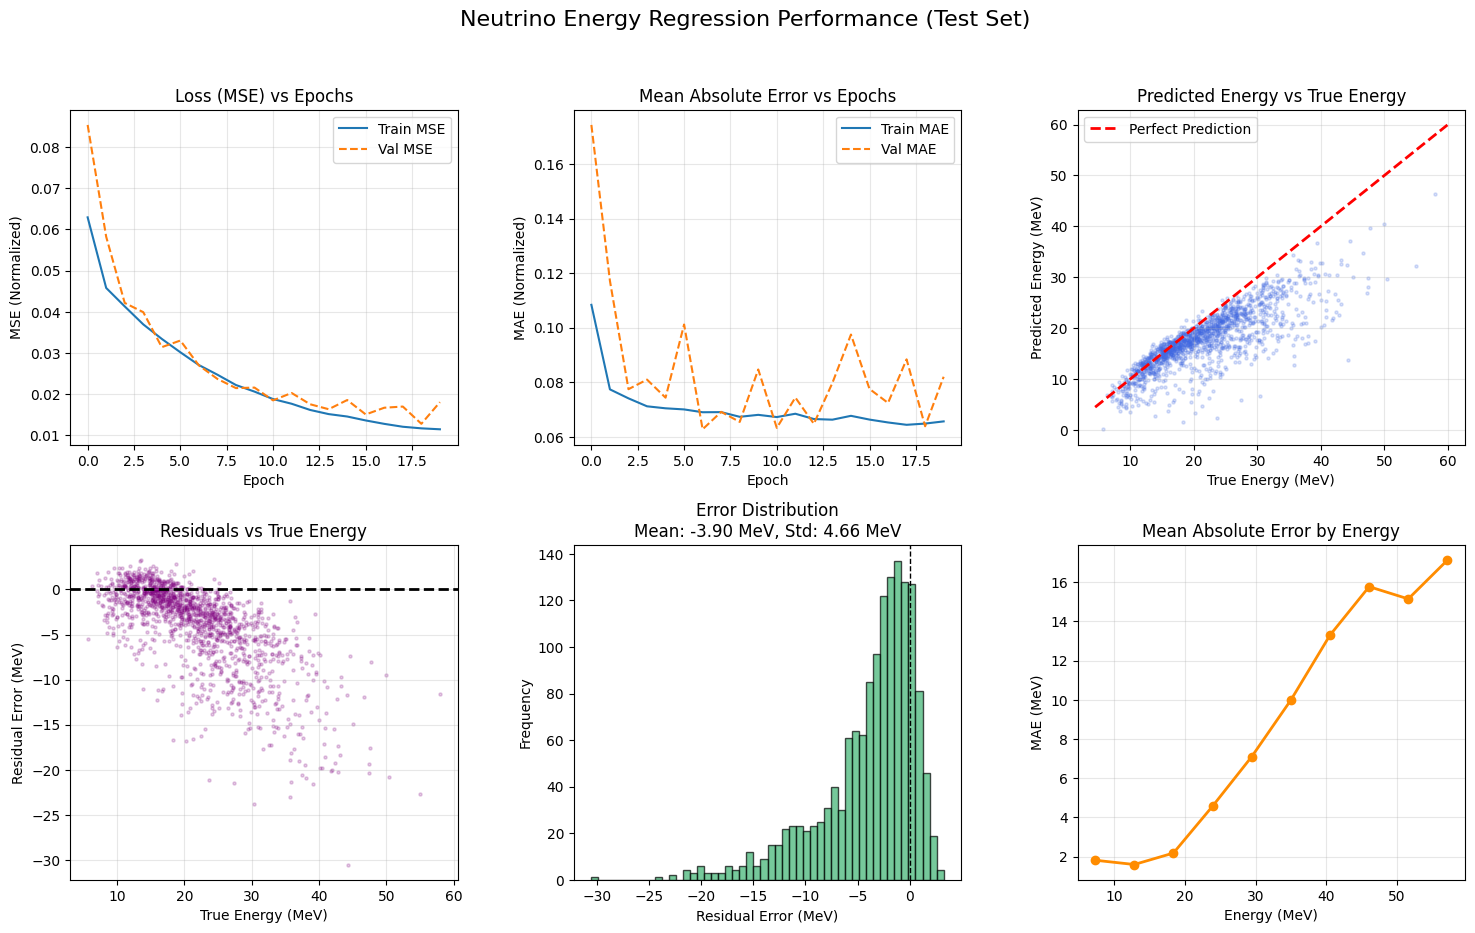

In [ ]:
def evaluate_energy_model(model, history, X_test, y_test, min_energy=4.49, max_energy=59.93):
    """
    Plots a 6-panel summary of regression performance in physical units (MeV).
    """
    # Get predictions and un-normalise data back to MeV
    y_pred_norm = model.predict(X_test, verbose=0).flatten()
    
    # Formula: real = normalised * (max - min) + min
    range_mev = max_energy - min_energy
    y_true_mev = y_test * range_mev + min_energy
    y_pred_mev = y_pred_norm * range_mev + min_energy
    
    # Calculate Residuals (Prediction - Truth)
    residuals = y_pred_mev - y_true_mev

    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # subplot 1: MSE Loss
    ax = axes[0, 0]
    ax.plot(history.history['loss'], label='Train MSE')
    ax.plot(history.history['val_loss'], label='Val MSE', linestyle='--')
    ax.set_title('Loss (MSE) vs Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE (Normalized)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # subplot 2: MAE 
    ax = axes[0, 1]
    ax.plot(history.history['mae'], label='Train MAE')
    ax.plot(history.history['val_mae'], label='Val MAE', linestyle='--')
    ax.set_title('Mean Absolute Error vs Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MAE (Normalized)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # subplot 3: Predicted vs True 
    ax = axes[0, 2]
    ax.scatter(y_true_mev, y_pred_mev, alpha=0.2, s=5, color='royalblue')
    # Perfect prediction line (y=x)
    lims = [min_energy, max_energy]
    ax.plot(lims, lims, 'r--', lw=2, label='Perfect Prediction')
    ax.set_title('Predicted Energy vs True Energy')
    ax.set_xlabel('True Energy (MeV)')
    ax.set_ylabel('Predicted Energy (MeV)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # subplot 4: Residuals vs True Energy
    ax = axes[1, 0]
    ax.scatter(y_true_mev, residuals, alpha=0.2, s=5, color='purple')
    ax.axhline(0, color='black', linestyle='--', lw=2)
    ax.set_title('Residuals vs True Energy')
    ax.set_xlabel('True Energy (MeV)')
    ax.set_ylabel('Residual Error (MeV)')
    ax.grid(True, alpha=0.3)

    # subplot 5: Residual Histogram
    ax = axes[1, 1]
    ax.hist(residuals, bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
    ax.axvline(0, color='black', linestyle='--', lw=1)
    ax.set_title(f'Error Distribution\nMean: {np.mean(residuals):.2f} MeV, Std: {np.std(residuals):.2f} MeV')
    ax.set_xlabel('Residual Error (MeV)')
    ax.set_ylabel('Frequency')
    
    # subplot 6: MAE by Energy Range 
    ax = axes[1, 2]
    # Create 10 energy bins
    bins = np.linspace(min_energy, max_energy, 11)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_indices = np.digitize(y_true_mev, bins)
    
    # Calculate MAE for each bin
    bin_maes = []
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            bin_maes.append(np.mean(np.abs(residuals[mask])))
        else:
            bin_maes.append(0)
            
    ax.plot(bin_centers, bin_maes, marker='o', linestyle='-', color='darkorange', lw=2)
    ax.set_title('Mean Absolute Error by Energy')
    ax.set_xlabel('Energy (MeV)')
    ax.set_ylabel('MAE (MeV)')
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'Neutrino Energy Regression Performance (Test Set)', fontsize=16)
    plt.show()

# Run the function 
evaluate_energy_model(
    task5_neutrino_optimised, 
    history, 
    X_test_neutrino, 
    y_test_neutrino
)

### Extending to the Electron Energy

Let's try use the same model now for the electron energy:

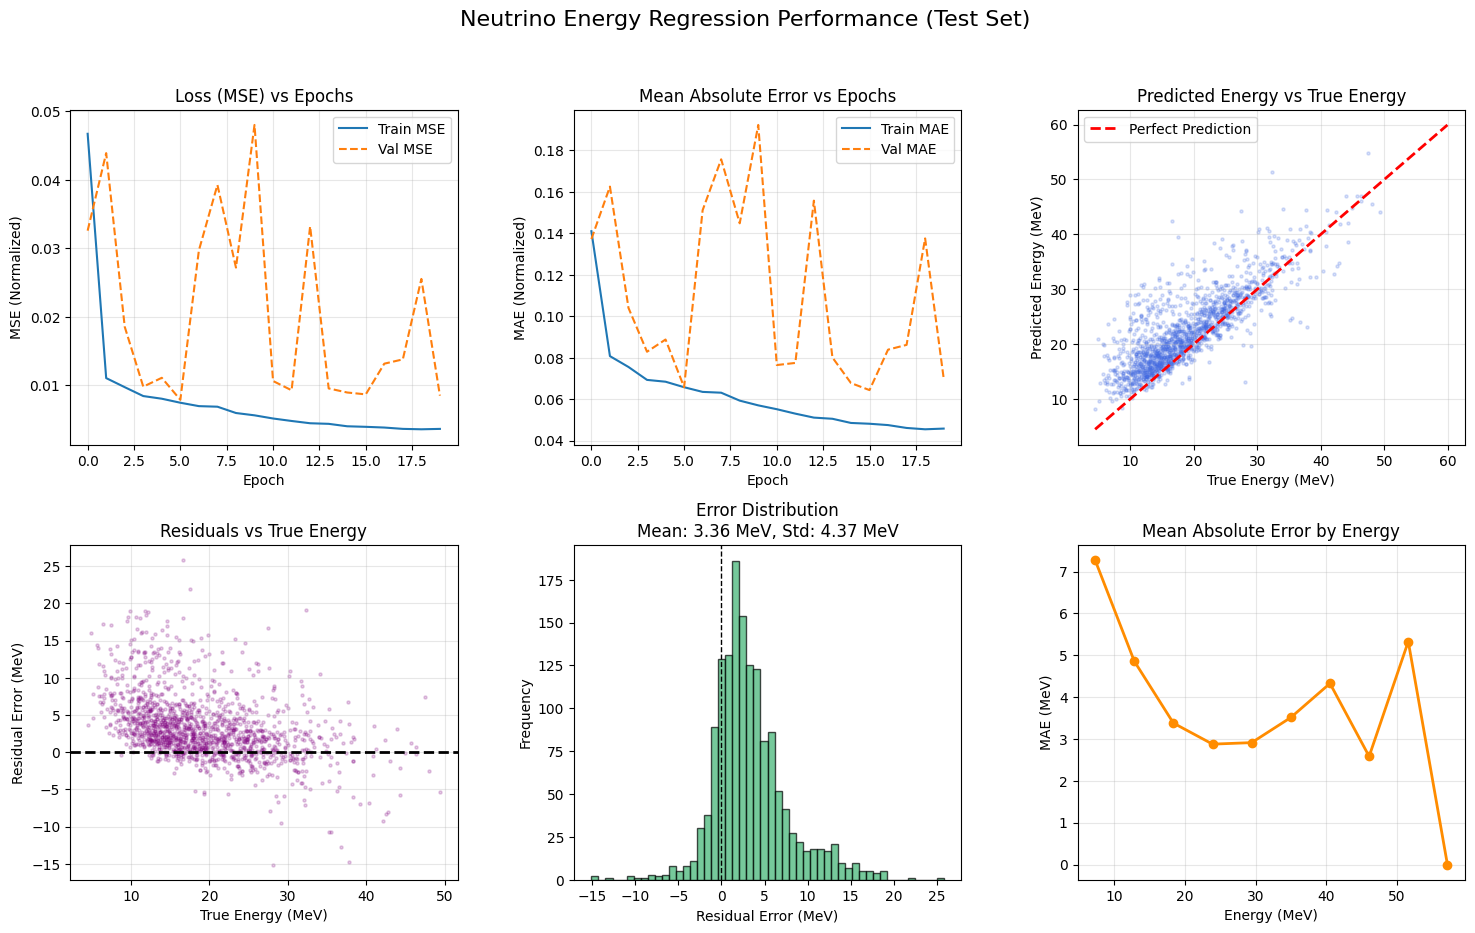

In [34]:
# Create Training, Validation, Testing Datasets
X_train, y_train, X_val, y_val, X_test, y_test = energy_training_data(
    lar_images,
    electron_energy,
)

# Evaluate
evaluate_energy_model(
    task5_neutrino_optimised, 
    history, 
    X_test, 
    y_test
)


# Task 6: Denoising Algorithm

Now we consider making an effective denoising algorithm. From previous attempts, it was discovered that autoencoders, although effective at reducing noise, lose fine details of the neutrino tracks due to their inherent bottlenecks. This would be an annoying side-effect as it may make extracting info from these denoised images difficult.

As such, we try a U-Net Denoiser for this task. They use *skip connections* which allow some details (such as the neutrino track) to skip the bottleneck. We define one below:

In [ ]:
def build_denoising_unet(input_shape=(100, 100, 1)):
    inputs = Input(shape=input_shape)

    # Downsampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck layer
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    # Upsampling layers
    u1 = layers.UpSampling2D((2, 2))(b)
    # Skip connection is here
    merge1 = layers.Concatenate()([c2,u1]) 
    d1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge1)
    d1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d1)

    u2 = layers.UpSampling2D((2, 2))(d1)
    # Skip connection is here
    merge2 = layers.Concatenate()([c1,u2])
    d2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
    d2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(d2)

    # Output layers
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d2)

    model = models.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam', loss='mae',metrics=['mse'])
    
    return model

denoiser = build_denoising_unet()
denoiser.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_146 (Conv2D) │ (None, 100, 100,  │        320 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_147 (Conv2D) │ (None, 100, 100,  │      9,248 │ conv2d_146[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 50, 50,    │          0 │ conv2d_147[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_148 (Conv2D) │ (None, 50, 50,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_149 (Conv2D) │ (None, 50, 50,    │     36,928 │ conv2d_148[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 25, 25,    │          0 │ conv2d_149[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_150 (Conv2D) │ (None, 25, 25,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_151 (Conv2D) │ (None, 25, 25,    │    147,584 │ conv2d_150[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 50, 50,    │          0 │ conv2d_151[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50, 50,    │          0 │ conv2d_149[0][0], │
│ (Concatenate)       │ 192)              │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_152 (Conv2D) │ (None, 50, 50,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 50, 50,    │     36,928 │ conv2d_152[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 100, 100,  │          0 │ conv2d_153[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100, 100,  │          0 │ conv2d_147[0][0], │
│ (Concatenate)       │ 96)               │            │ up_sampling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 100, 100,  │     27,680 │ concatenate_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 100, 100,  │      9,248 │ conv2d_154[0][0]

 Total params: 470,977 (1.80 MB)

 Trainable params: 470,977 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def prepare_denoising_data(images, num_of_images, noise_range, normalise='min-max', trn_val_tst_ratio=[0.7, 0.15, 0.15]):
    '''
    Generates dataset for training our Denoiser.
    Input (X): Noisy Images
    Target (Y): Clean Images
    '''
    # Shuffle indices
    shuffled_indices = np.random.permutation(len(images))[:num_of_images]
    
    clean_images = images[shuffled_indices]     # clean images
    noisy_images = np.zeros_like(clean_images)  # noisy images
    
    for i in range(len(clean_images)):
        # Add random noise level to each image
        current_stdev = np.random.uniform(noise_range[0], noise_range[1])
        noise = gaussian_noise((100, 100), current_stdev) 
        noisy_images[i] = clean_images[i] + noise

    # Normalise images together - a rather inelegant way by concatenation -> normalisation -> split apart again
    combined_images = np.concatenate([clean_images, noisy_images], axis=0) # combine
    
    # Normalise by max value if boolean is true:
    if normalise=='min-max':
        combined_norm = normalise_intensity(combined_images) 
    elif normalise =='by_max':
        combined_norm = combined_images / np.max(combined_images)
    elif normalise =='none':
        combined_norm = combined_images
        
    
    split_point = len(clean_images)   # split apart
    clean_images_norm = combined_norm[:split_point]
    noisy_images_norm = combined_norm[split_point:]
    
    # Add Channel Dimension for CNN
    clean_images_norm = np.expand_dims(clean_images_norm, axis=-1)
    noisy_images_norm = np.expand_dims(noisy_images_norm, axis=-1)

    # Split 
    num_total = len(clean_images_norm)
    train_end = int(trn_val_tst_ratio[0] * num_total)
    val_end = train_end + int(trn_val_tst_ratio[1] * num_total)

    # Inputs
    X_train = noisy_images_norm[:train_end]
    X_val = noisy_images_norm[train_end:val_end]
    X_test = noisy_images_norm[val_end:]

    # Targets
    y_train = clean_images_norm[:train_end]
    y_val = clean_images_norm[train_end:val_end]
    y_test = clean_images_norm[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# Create Training, Validation, Testing Datasets
X_train, y_train, X_val, y_val, X_test, y_test = prepare_denoising_data(
    lar_images,
    num_of_images=10000,
    noise_range=[0,6]
)

# Add early stopping to save time
early_stop = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=3,                
    restore_best_weights=True  # Reverts to best weights and not latest one
)

# Train model
print(f'Training Denoiser Model:')
history = denoiser.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val,y_val),
    callbacks=[early_stop],
    verbose=1
)

Training Denoiser Model:
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 437ms/step - loss: 0.0099 - mse: 0.0043 - val_loss: 2.0963e-04 - val_mse: 2.3447e-05
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 440ms/step - loss: 2.0523e-04 - mse: 2.3063e-05 - val_loss: 2.0963e-04 - val_mse: 2.3447e-05
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 441ms/step - loss: 2.0523e-04 - mse: 2.3063e-05 - val_loss: 2.0963e-04 - val_mse: 2.3447e-05
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 440ms/step - loss: 2.0523e-04 - mse: 2.3063e-05 - val_loss: 2.0963e-04 - val_mse: 2.3447e-05


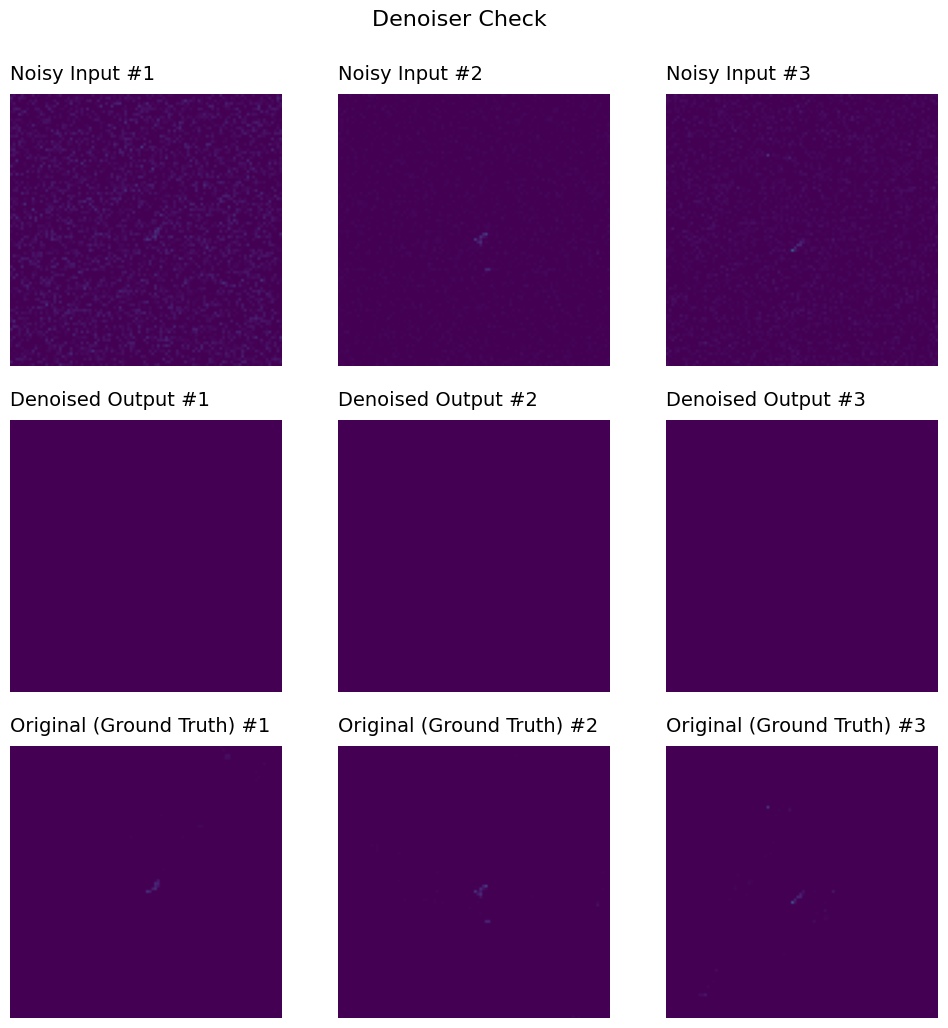

In [ ]:
# Extract clean, noisy, predicted data
indices = np.random.choice(len(X_test), 3, replace=False)
noisy = X_test[indices]
clean = y_test[indices]
denoised = denoiser.predict(noisy, verbose=0)

# Squeeze and group them into a list so we can loop over them easily
image_rows = [noisy.squeeze(), denoised.squeeze(), clean.squeeze()]
row_titles = ['Noisy Input', 'Denoised Output', 'Original (Ground Truth)']

# Plot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Loop over the 3 rows (Noisy -> Denoised -> Clean)
for row_no, (images, title) in enumerate(zip(image_rows, row_titles)):
    # Loop through columns
    for col_no in range(3):
        # Row title only goes to left column
        axes[row_no, col_no].set_title(f'{title} #{col_no+1}', fontsize=14, loc='left', pad=10)

        ax = axes[row_no, col_no]
        ax.imshow(images[col_no], cmap='viridis', vmin=0, vmax=1)
        ax.axis('off')

plt.suptitle('Denoiser Check', fontsize=16, y=0.95)
plt.show()

### Observations

It is evident that our neutrino tracks are too dim compared to the noise, even at noise levels between 2-6 stdev. This is likely due to our min-max normalisation reserving the larger intensity values for our outlier neutrinos with massive intensities. 

This seems to have caused an issue where the model is conditioned to output a blank slate as this performs better for its overall metrics, seeing as a. the neutrinos are so dim and b. the neutrinos occupy such little space within the image. 

I first thought the best way forward was to introduce a custom MAE function, where a correctly-outputted neutrino value was worth far more to reduce loss than a correct noise value. However, this didn't solve our issues and it was decided that the main problem was data preprocessing.

As evident in the graph above, neutrino tracks are nearly invisible due to the intense outliers. I then tried to add a bit of preprocessing to clip the outliers (above 95th percentile) before normalisation, with the intention of making the bulk of tracks more visible. This didn't solve the issue either.

Finally, we try switching the normalisation mode from min-max to just dividing by global maximum, in hopes that the bulk of neutrino values don't start from zero:

In [ ]:
# Create New Training, Validation, Testing Datasets
X_train, y_train, X_val, y_val, X_test, y_test = prepare_denoising_data(
    lar_images,
    num_of_images=10000,
    noise_range=[0,6],
    normalise='by_max'
)

print("Max value in Clean Images:", y_train.max())
print("Mean value in Clean Images:", y_train.mean())

Max value in Clean Images: 0.9650420737815304
Mean value in Clean Images: 0.00020733293178517892


In [ ]:
# New model
denoiser_new = build_denoising_unet()

# Add early stopping to save time
callbacks = [
    EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=3,                
    restore_best_weights=True  # Reverts to best weights and not latest one
),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,min_lr=1e-7)  # reduce learning rate on a loss plateau
    ]

# Train model
print(f'Training Updated Denoiser Model:')
history = denoiser_new.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val,y_val),
    callbacks=[callbacks],
    verbose=1
)

Training Updated Denoiser Model:
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 437ms/step - loss: 0.0120 - mse: 0.0053 - val_loss: 2.0563e-04 - val_mse: 2.2907e-05 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 439ms/step - loss: 2.0733e-04 - mse: 2.3209e-05 - val_loss: 2.0563e-04 - val_mse: 2.2907e-05 - learning_rate: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 439ms/step - loss: 2.0733e-04 - mse: 2.3209e-05 - val_loss: 2.0563e-04 - val_mse: 2.2907e-05 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 96s 439ms/step - loss: 2.0733e-04 - mse: 2.3209e-05 - val_loss: 2.0563e-04 - val_mse: 2.2907e-05 - learning_rate: 0.0010


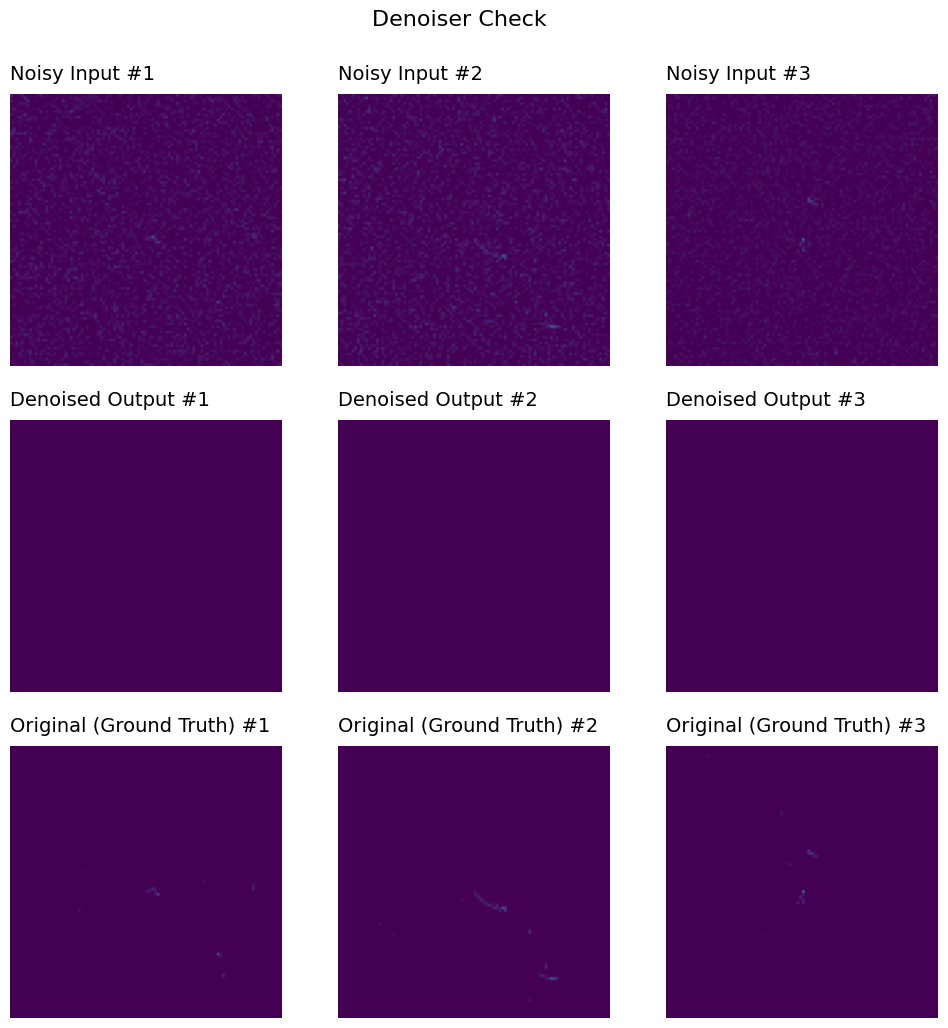

In [ ]:
# Extract clean, noisy, predicted data
indices = np.random.choice(len(X_test), 3, replace=False)
noisy = X_test[indices]
clean = y_test[indices]
denoised = denoiser_new.predict(noisy, verbose=0)

# Squeeze and group them into a list so we can loop over them easily
image_rows = [noisy.squeeze(), denoised.squeeze(), clean.squeeze()]
row_titles = ['Noisy Input', 'Denoised Output', 'Original (Ground Truth)']

# Plot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Loop over the 3 rows (Noisy -> Denoised -> Clean)
for row_no, (images, title) in enumerate(zip(image_rows, row_titles)):
    # Loop through columns
    for col_no in range(3):
        # Row title only goes to left column
        axes[row_no, col_no].set_title(f'{title} #{col_no+1}', fontsize=14, loc='left', pad=10)

        ax = axes[row_no, col_no]
        ax.imshow(images[col_no], cmap='viridis', vmin=0, vmax=1)
        ax.axis('off')

plt.suptitle('Denoiser Check', fontsize=16, y=0.95)
plt.show()

It seems that this also is unable to solve our issue. In a last-ditch effort, let's try without any normalisation:

In [ ]:
# Create New Training, Validation, Testing Datasets
X_train, y_train, X_val, y_val, X_test, y_test = prepare_denoising_data(
    lar_images,
    num_of_images=10000,
    noise_range=[0,6],
    normalise='none'
)

# New model
denoiser_unnormalised = build_denoising_unet()

# Add early stopping to save time
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,min_lr=1e-7)  # reduce learning rate on a loss plateau
    ]

# Train model
print(f'Training Updated Denoiser Model:')
history = denoiser_unnormalised.fit(
    X_train,y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val,y_val),
    callbacks=[callbacks],
    verbose=1
)

Training Updated Denoiser Model:
Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 94s 424ms/step - loss: 0.0292 - mse: 0.2667 - val_loss: 0.0220 - val_mse: 0.2666 - learning_rate: 0.0010
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 424ms/step - loss: 0.0220 - mse: 0.2635 - val_loss: 0.0220 - val_mse: 0.2666 - learning_rate: 0.0010
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 90s 409ms/step - loss: 0.0220 - mse: 0.2635 - val_loss: 0.0220 - val_mse: 0.2666 - learning_rate: 0.0010
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 87s 398ms/step - loss: 0.0220 - mse: 0.2635 - val_loss: 0.0220 - val_mse: 0.2666 - learning_rate: 0.0010
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 91s 416ms/step - loss: 0.0220 - mse: 0.2635 - val_loss: 0.0220 - val_mse: 0.2666 - learning_rate: 5.0000e-04
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 95s 432ms/step - loss: 0.0220 - mse: 0.2635 - val_loss: 0.0220 - val_mse: 0.2666 - learning_rate: 5.0000e-04
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 93s 427ms/step - loss: 0.0220 - mse: 0.2635 - val

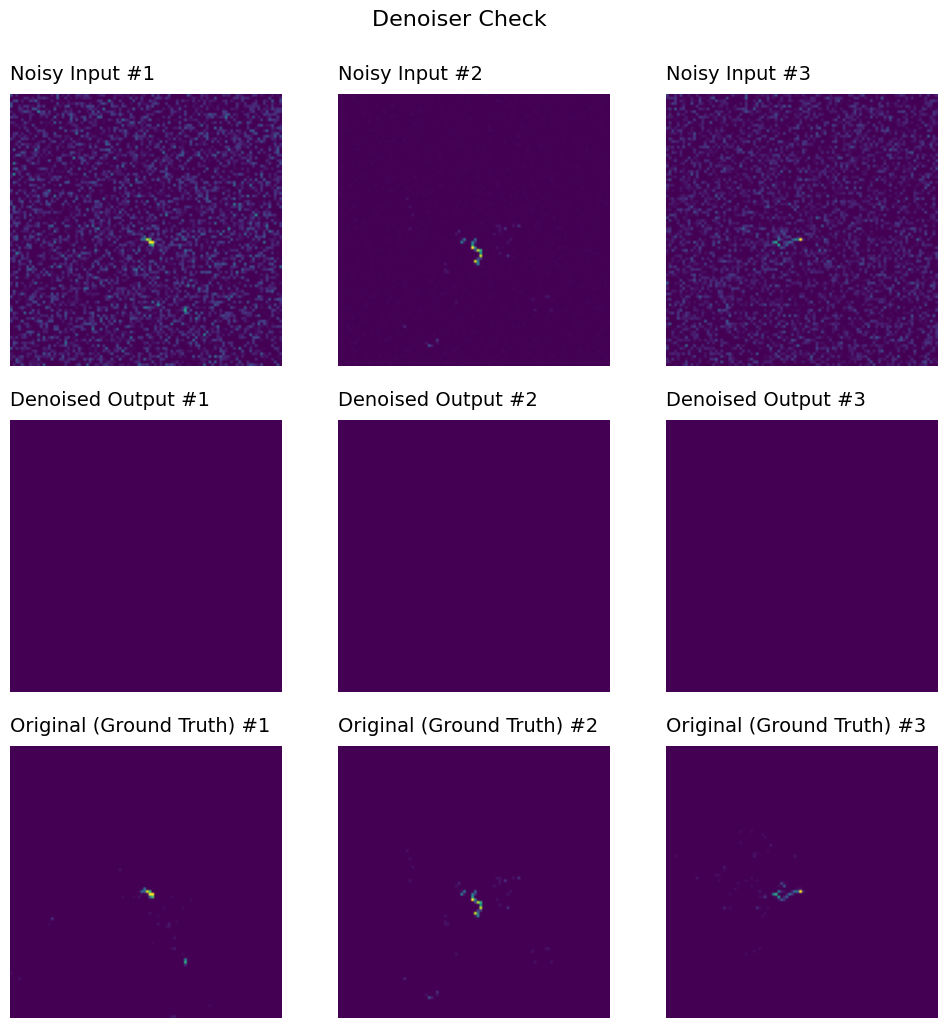

In [ ]:
# Extract clean, noisy, predicted data
indices = np.random.choice(len(X_test), 3, replace=False)
noisy = X_test[indices]
clean = y_test[indices]
denoised = denoiser_unnormalised.predict(noisy, verbose=0)

# Squeeze and group them into a list so we can loop over them easily
image_rows = [noisy.squeeze(), denoised.squeeze(), clean.squeeze()]
row_titles = ['Noisy Input', 'Denoised Output', 'Original (Ground Truth)']

# Plot
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

# Loop over the 3 rows (Noisy -> Denoised -> Clean)
for row_no, (images, title) in enumerate(zip(image_rows, row_titles)):
    # Loop through columns
    for col_no in range(3):
        # Row title only goes to left column
        axes[row_no, col_no].set_title(f'{title} #{col_no+1}', fontsize=14, loc='left', pad=10)

        ax = axes[row_no, col_no]
        ax.imshow(images[col_no], cmap='viridis')
        ax.axis('off')

plt.suptitle('Denoiser Check', fontsize=16, y=0.95)
plt.show()